# Parse data from .txt or .csv files

In [1]:
import csv


def parse_txt(filename, oriented=True):
    """
    Parse data from txt file into dict python type.
    JSON serializable.
    """
    data = {}
    with open(filename) as file:

        line = file.readline()
        while line:

            # skip comments
            if line[0] == '#':
                line = file.readline()
                continue

            parent, child = line.split()
            parent = int(parent)
            child = int(child)

            # rows in data file can be duplicated
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = {
                    'linked': [child],
                    'distances': {},
                    'paths':{},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }

            if oriented:
                if child not in data:
                    data[child] = {
                        'linked': [],
                        'distances': {},
                        'paths':{},
                        'degree': 0,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'paths':{},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

            line = file.readline()

    return data


def parse_csv(filename, oriented=True):
    data = {}

    with open(filename) as file:
        reader = csv.reader(file)
        next(reader)

        for row in reader:

            parent = int(row[0])
            child = int(row[1])

            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = {
                    'linked': [child],
                    'distances': {},
                    'paths':{},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }

            if oriented:
                if child not in data:
                    data[child] = {
                        'linked': [],
                        'distances': {},
                        'paths':{},
                        'degree': 0,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'paths':{},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

    return data


def parse(filename, oriented=True):
    if filename.split('.')[-1] == 'txt':
        return parse_txt(filename, oriented)
    elif filename.split('.')[-1] == 'csv':
        return parse_csv(filename, oriented)

# Distance counting method with modifications

In [2]:
from collections import deque 
import datetime as dt

def count_distance(vertice, data, h = -1, full=False, save_paths=False, rollback=True, monitoring=False):
    """
    Counts distances form given vertice to all other in connectivity component that vertice belongs to.
    Also, of h parameter is provided, this method finds list of vertices which are h or less away from provided vertice.
    (As only distance from provided vertive becomes more then h method stops.)
    Based on BFS.
    Saves paths if neccessary.
    vertice: index of source vertice
    data: dict with information about graph
    h: distance to closest vertices
    full: complete BFS in spite of current distance > h
    save_paths: saves paths to vertices from source vertice
    """

    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    current_distance = 0
    centrality = 0
    vertices_number = 1
    nearest_vertices = []
    d0 = deque()
    d1 = deque()
    
    source_active = data[vertice]['active']
    
    d0.append(vertice)
    data[vertice]['marked'] = True
    
    if save_paths:
        data[vertice]['paths'][vertice] = [vertice, ]
    
    operations_counter += 10
    
    while True:
        
        if (not d0 and not d1) or (h != -1 and current_distance > h and not full):
            operations_counter += 9
            break
        
        if current_distance % 2 == 0:
            
            v = d0.popleft()
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d1.append(i)
                    data[i]['marked'] = True
                    
                    if save_paths:
                        path = data[v]['paths'][vertice].copy()
                        path.append(i)
                        data[i]['paths'][vertice] = path
                        
                        operations_counter += len(data[v]['paths'][vertice]) + 2
                    
                    operations_counter += 3
                operations_counter += 2
            
            data[v]['distances'][vertice] = current_distance
            vertices_number += 1
            centrality += current_distance
            
            # set active to false if it vertice 'v' is too close to source vertice 'vertice'
            if h != -1 and current_distance <= h:
                data[v]['active'] = False
                nearest_vertices.append(v)
                
                operations_counter += 2
                
            # go to the next level of distance from the source vertice 'vertice'
            if not d0:
                current_distance += 1
                                
                operations_counter += 1
                
            operations_counter += 5 # number of "if"'s
                
        else:
            
            v = d1.popleft()
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d0.append(i)
                    data[i]['marked'] = True
                    
                    if save_paths:
                        path = data[v]['paths'][vertice].copy()
                        path.append(i)
                        data[i]['paths'][vertice] = path
                        
                        operations_counter += len(data[v]['paths'][vertice]) + 2
                    
                    operations_counter += 3
                operations_counter += 2
            
            data[v]['distances'][vertice] = current_distance
            vertices_number += 1
            centrality += current_distance
            
            # set active to false if it vertice 'v' is too close to source vertice 'vertice'
            if h != -1 and current_distance <= h:
                data[v]['active'] = False
                nearest_vertices.append(v)
                
                operations_counter += 3
            
            # go to the next level of distance from the source vertice 'vertice'
            if not d1:
                current_distance += 1
                
                operations_counter += 1
                
            operations_counter += 5 # number of "if"'s added
    
    # rollback data
    if rollback:
        for key, value in data.items():
            value['marked'] = False
    
    # set initial status
    data[vertice]['active'] = source_active
    
    operations_counter =+ 1
    
    if full:
        data[vertice]['centrality'] = centrality / vertices_number
        operations_counter += 4
        
        if h == -1:
            if monitoring:
                return operations_counter, dt.datetime.now() - timestamp_before_algorithm
        else:
            if monitoring:
                return nearest_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return nearest_vertices
    else:
        if h == -1:
    
            data[vertice]['centrality'] = centrality / vertices_number
            operations_counter += 5
            
            if monitoring:
                return operations_counter, dt.datetime.now() - timestamp_before_algorithm
        else:
            if monitoring:
                return nearest_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return nearest_vertices

# Select landmarks using random, degree or centrality ranking

In [3]:
import random
from math import log
import datetime as dt

def select_landmarks(
    data: dict,
    number_of_landmarks = 0.1,
    ranking: str = 'degree',
    h: int = 1,
    rollback=False,
    monitoring=False
):
    """
    Select landmarks using constratined strategy with provided h and ranking parameters.
    Sometimes it is impossible to select provided amount of landmarks.
    It happens because of proximity of vertices most suitable for beeing selected as landmark.
    Such situation can be changed if you decide to set h to -1
    In this case method selects as many landmarks as possible.
    Set h to -1 to get top 'number_of_landmarks' ranked vertices.
    Possible ranking: degree, random, closeness.
    Set rollback to True to roll back all vertices 'active' to True
    """
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    data_items = data.items()
    graph_size = len(data_items)
    
    if number_of_landmarks <= 0:
        return []
    
    number_of_landmarks = int(
        graph_size * (number_of_landmarks / 100)
    ) if number_of_landmarks >= 1 else int(
        graph_size * number_of_landmarks
    )
    
    landmarks = []
    
    operations_counter += graph_size + 5
    
    
    if ranking == 'random':
        
        vertices = [i[0] for i in data_items]
        random.shuffle(vertices)
        
        if h == -1:
            
            random_vertices = vertices[:number_of_landmarks]
            
            for v in random_vertices:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, save_paths=True, monitoring=True)
                operations_counter += operations + 1
            
            operations_counter += 1 + number_of_landmarks + graph_size
            
            if monitoring:
                return random_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return random_vertices

        operations_counter += graph_size + number_of_landmarks + len(vertices) + 1
        
        while len(landmarks) < number_of_landmarks and vertices:
            
            v = vertices.pop(0)
            
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
            
            landmarks.append(v)
            _, operations, __ = count_distance(vertice=v, data=data, h=h, full=True, save_paths=True, monitoring=True)
            
            operations_counter += operations + 3
    
    
    elif ranking == 'degree':
        
        data_sorted = sorted(data_items, key=lambda x: x[1]['degree'], reverse=True)
        
        operations_counter += graph_size * log(graph_size)
        
        if h == -1:
            
            max_degree_vertices = [i[0] for i in data_sorted[:number_of_landmarks]]
            
            for v in max_degree_vertices:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, save_paths=True, monitoring=True)
                operations_counter += operations + 1
            
            operations_counter += 2 * number_of_landmarks + 1
            if monitoring:
                return max_degree_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return max_degree_vertices
        
        while len(landmarks) < number_of_landmarks and data_sorted:
            v = data_sorted.pop(0)[0]
            
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
                
            landmarks.append(v)
            _, operations, __ = count_distance(vertice=v, data=data, h=h, full=True, save_paths=True, monitoring=True)
            
            operations_counter += operations + 3
            
    
    elif ranking == 'closeness':
        
        shuffled_vertices = [i[0] for i in data_items]
        random.shuffle(shuffled_vertices)
        
        number_of_seeds = int(
            number_of_landmarks + (graph_size - number_of_landmarks) / 2
        ) if number_of_landmarks >= (graph_size / 2) else number_of_landmarks * 2
        
        operations_counter += 2 * graph_size + 6
        
        seeds = []
        
        if h == -1:
            
            while len(seeds) < number_of_seeds and shuffled_vertices:
                seed = shuffled_vertices.pop(0)
                if data[seed]['linked']:
                    operations, __ = count_distance(vertice=seed, data=data, h=-1, full=True, save_paths=True, monitoring=True)
                    seeds.append(seed)
                    
                    operations_counter += operations
                operations_counter += 2
                
            # select top 'number_of_landmarks' vertices with lowest closeness centrality
            min_centrality_vertices = [
                i[0] for i in sorted(
                    [(key, value['centrality']) for key, value in data.items() if key in seeds],
                    key=lambda x: x[1]
                )[:number_of_landmarks]
            ]
            
            operations_counter += len(seeds) + log(len(seeds)) * len(seeds)
            if monitoring:
                return min_centrality_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return min_centrality_vertices
        
        while len(seeds) < number_of_seeds and shuffled_vertices:
            seed = shuffled_vertices.pop(0)
            if data[seed]['linked']:
                _, operations, __ = count_distance(vertice=seed, data=data, h=h, full=True, save_paths=True, monitoring=True)
                seeds.append(seed)
                
                operations_counter += operations + 1
            operations_counter += 2

        # sort seeds by closeness centrality ascending
        seeds_sorted = [
            i[0] for i in sorted(
                [(key, value['centrality']) for key, value in data.items() if key in seeds],
                key=lambda x: x[1]
            )
        ]
        
        landmarks.append(seeds_sorted.pop(0))

        operations_counter += graph_size + len(seeds) * log(len(seeds))

        while len(landmarks) < number_of_landmarks:
            
            if not seeds_sorted:

                # iteration by remaining shuffled vertices
                for seed in shuffled_vertices:
                    if len(landmarks) >= number_of_landmarks:
                        break
                    if data[seed]['active']:
                        _, operations, __ = count_distance(vertice=seed, data=data, h=h, full=True, save_paths=True, monitoring=True)
                        landmarks.append(seed)
                        operations_counter += operations + 1
                    
                    operations_counter += 2
                break
            
            landmarks.append(seeds_sorted.pop(0))
            
            operations_counter += 3
            
    # data rollback
    if rollback:
        for key, value in data.items():
            value['active'] = True
                
    if monitoring:
        return landmarks, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return landmarks

# BFS

In [4]:
import datetime as dt

def bfs(source, stock, data, rollback=True, monitoring=False):
    """
    Count distance from source to stock without using landmarks.
    Pure BFS.
    """
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()

    if not all(key in data for key in (source, stock)):
        print('Key not found')
        operations_counter += 2 * len(data.items())
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1

    current_distance = 0
    flag_found = False
    d0 = deque()
    d1 = deque()

    d0.append(source)
    data[source]['marked'] = True

    operations_counter += 7

    while True:

        if not d0 and not d1:
            current_distance = -1

            operations_counter += 3
            break

        if current_distance % 2 == 0:

            v = d0.popleft()

            if v == stock:
                flag_found = True

                operations_counter += 1
                break

            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d1.append(i)
                    data[i]['marked'] = True

                    operations_counter += 2
                operations_counter += 2

            if not d0:
                current_distance += 1

                operations_counter += 1

            operations_counter += 3

        else:

            v = d1.popleft()

            if v == stock:
                flag_found = True
                break

            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d0.append(i)
                    data[i]['marked'] = True

                    operations_counter += 2
                operations_counter += 2

            if not d1:
                current_distance += 1

                operations_counter += 1

            operations_counter += 3

    if rollback:
        for key, value in data.items():
            value['marked'] = False

    if flag_found:
        if monitoring:
            return current_distance, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return current_distance
    else:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1

# Shortest path estimating via landmarks method

In [5]:
import datetime as dt

def shortest_path(
    source,
    stock,
    landmarks,
    data,
    estimation_strategy='geometrical_mean',
    monitoring=False
):
    """
    Analogue of Landmarks-basic.
    Counts distance from source to stock using landmarks.
    For distance estimation geometric mean is used.
    There are 4 estimation strategies: geometrical mean, upper, lower and middle point. Geometrical mean is default.
    source: source vertice id
    stock: stock vertice id
    landmarks: list of landmarks
    data: dict with graph data
    estimation_strategy: estimation strategy used to calculate distance from source to stock
    """
    
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    # check if source or stock is not in graph
    try:
        source_distances = data[source]['distances']
        stock_distances = data[stock]['distances']
    except KeyError:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    L = -1
    U = 3 * len(data.items())
    
    operations_counter += 5
    
    for key, to_source in source_distances.items():
        
        to_stock = stock_distances.get(key, -1)
        if to_stock == -1:
            continue
        
        l = abs(to_source - to_stock)
        u = to_source + to_stock
        
        if l > L:
            L = l
            operations_counter += 1
        if u < U:
            U = u
            operations_counter += 1
            
        operations_counter += 10
            
    # if source and stock are in different connectivity components
    if L == -1 and U == 3 * len(data.items()):
        
        operations_counter += 3
        
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    # choose estimating strategy
    if estimation_strategy == 'geometrical_mean':
        result = (L * U) ** 0.5
        operations_counter += 3
    elif estimation_strategy == 'middle_point':
        result = (L + U) / 2
        operations_counter += 3
    elif estimation_strategy == 'upper':
        result = U
        operations_counter += 2
    elif estimation_strategy == 'lower':
        result = L
        operations_counter += 2
    else:
        result = (L * U) ** 0.5
        operations_counter += 3
    
    if monitoring:
        return result, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return result

# Shortest path finding method using Landmakrs-BFS

In [6]:
import datetime as dt

def landmarks_bfs(
    source,
    stock,
    data,
    rollback=True,
    monitoring=False
):
    """
    Counts distance from source to stock using landmarks.
    Based on Landmarks-BFS strategy.
    source: source vertice id
    stock: stock vertice id
    data: dict with graph data
    """
    
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    # check if source or stock is not in graph
    try:
        source_paths = data[source]['paths']
        stock_paths = data[stock]['paths']
    except KeyError:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1    
    
    subgraph = {}
    
    operations_counter = 3
    
    for landmark, path in list(source_paths.items()) + list(stock_paths.items()):
        for v in range(len(path)-1):
            if path[v] in subgraph:
                subgraph[path[v]]['linked'].append(path[v+1])
                
                operations_counter += 1
            else:
                subgraph[path[v]] = {
                    'linked': [path[v+1]],
                    'marked': False
                }
                
                operations_counter += 4
            
            if path[v+1] in subgraph:
                subgraph[path[v+1]]['linked'].append(path[v])
                
                operations_counter += 1
            else:
                subgraph[path[v+1]] = {
                    'linked': [path[v]],
                    'marked': False
                }
                
                operations_counter += 3
    
    result, operations, operating_time = bfs(source, stock, subgraph, rollback=False, monitoring=True)    
    
    operations_counter += operations + len(source_paths) + len(stock_paths) + 1
    
    # rollback data
    if rollback:
        for key, value in data.items():
            value['marked'] = False
    
    if monitoring:
        return result, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return result

In [7]:
data = {
    1: {
        'linked': [2,6],
        'distances': {},
        'paths':{},
        'degree': 2,
        'centrality': 0,
        'marked': False,
        'active': True
    },
    2: {
        'linked': [1,3],
        'distances': {},
        'paths':{},
        'degree': 2,
        'centrality': 0,
        'marked': False,
        'active': True
    },
    3: {
        'linked': [2,4,8,9],
        'distances': {},
        'paths':{},
        'degree': 4,
        'centrality': 0,
        'marked': False,
        'active': True
    },
    4: {
        'linked': [3,5],
        'distances': {},
        'paths':{},
        'degree': 2,
        'centrality': 0,
        'marked': False,
        'active': True
    },
    5: {
        'linked': [4,7],
        'distances': {},
        'paths':{},
        'degree': 2,
        'centrality': 0,
        'marked': False,
        'active': True
    },
    6: {
        'linked': [1,8],
        'distances': {},
        'paths':{},
        'degree': 2,
        'centrality': 0,
        'marked': False,
        'active': True
    },
    7: {
        'linked': [5,9],
        'distances': {},
        'paths':{},
        'degree': 2,
        'centrality': 0,
        'marked': False,
        'active': True
    },
    8: {
        'linked': [6,3],
        'distances': {},
        'paths':{},
        'degree': 2,
        'centrality': 0,
        'marked': False,
        'active': True
    },
    9: {
        'linked': [3,7],
        'distances': {},
        'paths':{},
        'degree': 1,
        'centrality': 0,
        'marked': False,
        'active': True
    }
}

count_distance(9, data, h = -1, full=True, save_paths=True, rollback=True, monitoring=False)
count_distance(8, data, h = -1, full=True, save_paths=True, rollback=True, monitoring=False)
print(data)
print('=' * 125)
print(landmarks_bfs(1, 5, data))

{1: {'linked': [2, 6], 'distances': {9: 3, 8: 2}, 'paths': {9: [9, 3, 2, 1], 8: [8, 6, 1]}, 'degree': 2, 'centrality': 0, 'marked': False, 'active': True}, 2: {'linked': [1, 3], 'distances': {9: 2, 8: 2}, 'paths': {9: [9, 3, 2], 8: [8, 3, 2]}, 'degree': 2, 'centrality': 0, 'marked': False, 'active': True}, 3: {'linked': [2, 4, 8, 9], 'distances': {9: 1, 8: 1}, 'paths': {9: [9, 3], 8: [8, 3]}, 'degree': 4, 'centrality': 0, 'marked': False, 'active': True}, 4: {'linked': [3, 5], 'distances': {9: 2, 8: 2}, 'paths': {9: [9, 3, 4], 8: [8, 3, 4]}, 'degree': 2, 'centrality': 0, 'marked': False, 'active': True}, 5: {'linked': [4, 7], 'distances': {9: 2, 8: 3}, 'paths': {9: [9, 7, 5], 8: [8, 3, 4, 5]}, 'degree': 2, 'centrality': 0, 'marked': False, 'active': True}, 6: {'linked': [1, 8], 'distances': {9: 3, 8: 1}, 'paths': {9: [9, 3, 8, 6], 8: [8, 6]}, 'degree': 2, 'centrality': 0, 'marked': False, 'active': True}, 7: {'linked': [5, 9], 'distances': {9: 1, 8: 3}, 'paths': {9: [9, 7], 8: [8, 3, 9

# Environment variables

In [11]:
FILENAME = '../datasets/email-Eu-core.txt'
ORIENTED = False
LANDMARKS_PERCENT_RANGE = range(5, 25, 5)
TEST_VERTICES_PERCENT = 10
USE_VERTICES_FROM_ONE_CONNECTIVITY_COMPONENT = False
SAVE_PLOTS = True
SAVE_FOLDER = './email-Eu-core-results-2-10-2-paths/'

# Calculate test results for usual plotting

In [12]:
import random
from itertools import product

data = parse(FILENAME, ORIENTED)
data_items = data.items()
graph_size = len(data_items)
print('Number of vertices in graph: ' + str(graph_size))

select_strategies = ('random', 'degree', 'closeness')
estimation_strategies = ('geometrical_mean', 'middle_point', 'upper', 'lower', 'landmarks_bfs')
# estimation_strategies = ('landmarks_bfs',)

test_vertices_number = int(
    graph_size * (TEST_VERTICES_PERCENT / 100)
) if TEST_VERTICES_PERCENT > 1 else int(
    graph_size * TEST_VERTICES_PERCENT
)

results = {
    'random': {},
    'degree': {},
    'closeness': {}
}

# complexity is more then O(n^5)
if USE_VERTICES_FROM_ONE_CONNECTIVITY_COMPONENT:
    vertices = [i[0] for i in data_items]
    prod = list(product(vertices, vertices))
    random.shuffle(prod)
    vertices_source = []
    vertices_stock = []
    while len(vertices_source) < test_vertices_number and prod:
        combination = prod.pop(0)
        source = combination[0]
        stock = combination[1]
        if source != stock and bfs(source, stock, data) != -1:
            vertices_source.append(source)
            vertices_stock.append(stock)
            print('=' * 126)
            print(source)
            print(stock)
            print('Source and stock vertices is on ' + str(len(vertices_source) / test_vertices_number) + ' full.')

else: 
    
    vertices = [i[0] for i in data_items]
    vertices_source = vertices.copy()
    random.shuffle(vertices_source)
    vertices_source = vertices_source[:test_vertices_number]

    vertices_stock = vertices.copy()
    random.shuffle(vertices_stock)
    vertices_stock = vertices_stock[:test_vertices_number]

# count test results for each type of calculation
for select in select_strategies:

    print('=' * 125)
    print(select)

    for percent in LANDMARKS_PERCENT_RANGE:
        
        print('=' * 125)
        print('Percent of landmarks: ' + str(percent))
        
        results[select][percent] = {
            'geometrical_mean': [],
            'middle_point': [],
            'upper': [],
            'lower': [],
            'landmarks_bfs': [],
            'selection_operations': 0,
            'selection_time': 0
        }
        
        # rollback data manually to use input graph data
        for k, v in data.items():
            v['distances'] = {}
            v['paths'] = {}
            v['centrality'] = 0

        landmarks, operations_landmarks_selection, time_operations_landmarks_selection = select_landmarks(
            data, percent, ranking=select, monitoring=True, rollback=True)
        
        print('=' * 125)
        print(landmarks)

        results[select][percent]['selection_operations'] = operations_landmarks_selection
        results[select][percent]['selection_time'] = time_operations_landmarks_selection.total_seconds() * 1000

        for estimation in estimation_strategies:

            print('=' * 125)
            print(estimation)

            for source, stock in zip(vertices_source,vertices_stock):

                print('=' * 125)
                print('Source: ' + str(source))
                if source in landmarks:
                    print('is landmark')
                print('Stock: ' + str(stock))
                if stock in landmarks:
                    print('is landmark')

                distance_bfs, operations_bfs, time_bfs = bfs(source, stock, data, monitoring=True)
                
                if estimation != 'landmarks_bfs':
                    distance_landmarks, operations_landmarks, time_landmarks = shortest_path(
                        source, stock, landmarks, data, estimation_strategy=estimation, monitoring=True
                    )
                else:
                    distance_landmarks, operations_landmarks, time_landmarks = landmarks_bfs(
                        source, stock, data, monitoring=True
                    )

                print('Distance BFS:' + str(distance_bfs))
                print('Distance Landmarks: ' + str(distance_landmarks))

#                 accuracy = abs(distance_bfs - distance_landmarks)
#                 operation_delta = abs(operations_bfs - operations_landmarks)
#                 time_delta = abs(time_bfs - time_landmarks)
                accuracy = distance_bfs - distance_landmarks
                operation_delta = operations_bfs - operations_landmarks
                time_delta = time_bfs.total_seconds() - time_landmarks.total_seconds()

                print('Accuracy: ' + str(accuracy))
                print('Operations delta: ' + str(operation_delta))
                print('Operating time delta: ' + str(time_delta))

                results[select][percent][estimation].append((accuracy, operation_delta, time_delta))

Number of vertices in graph: 1005
random
Percent of landmarks: 5
[137, 961, 912, 0, 916, 273, 834, 446, 189, 707, 714, 492, 650, 853, 948, 75, 762, 224, 366, 548, 614, 861, 923, 400, 39, 583, 683, 244, 119, 193, 345, 955, 206, 276, 49, 363, 528, 953, 330, 436, 464, 876, 634, 572, 841, 740, 783, 737, 863, 543]
geometrical_mean
Source: 65
Stock: 269
Distance BFS:2
Distance Landmarks: 1.7320508075688772
Accuracy: 0.2679491924311228
Operations delta: 27626
Operating time delta: 0.001001
Source: 48
Stock: 240
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 46005
Operating time delta: 0.003001
Source: 978
Stock: 372
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 20469
Operating time delta: 0.001
Source: 727
Stock: 754
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 21201
Operating time delta: 0.001
Source: 658
Stock: 436
is landmark
D

Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 69874
Operating time delta: 0.004001
Source: 330
is landmark
Stock: 861
is landmark
Distance BFS:4
Distance Landmarks: 4.0
Accuracy: 0.0
Operations delta: 69881
Operating time delta: 0.004001
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 1.7320508075688772
Accuracy: 0.2679491924311228
Operations delta: 45757
Operating time delta: 0.002
Source: 548
is landmark
Stock: 374
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 64765
Operating time delta: 0.004001
Source: 6
Stock: 717
Distance BFS:2
Distance Landmarks: 1.7320508075688772
Accuracy: 0.2679491924311228
Operations delta: 56729
Operating time delta: 0.003001
Source: 185
Stock: 797
Distance BFS:3
Distance Landmarks: 2.8284271247461903
Accuracy: 0.1715728752538097
Operations delta: 6894

Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 47736
Operating time delta: 0.003001
Source: 574
Stock: 758
Distance BFS:3
Distance Landmarks: 2.0
Accuracy: 1.0
Operations delta: 60503
Operating time delta: 0.003
Source: 390
Stock: 423
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 48941
Operating time delta: 0.002
Source: 204
Stock: 811
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 63862
Operating time delta: 0.003001
Source: 407
Stock: 856
Distance BFS:1
Distance Landmarks: 2.0
Accuracy: -1.0
Operations delta: 3157
Operating time delta: 0.001
Source: 740
is landmark
Stock: 639
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 60822
Operating time delta: 0.003001
Source: 667
Stock: 89
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 42590
Operating time delta: 0.002001
Source: 191
Stock: 510
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 61835
O

Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 46006
Operating time delta: 0.002
Source: 978
Stock: 372
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 20470
Operating time delta: 0.001
Source: 727
Stock: 754
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 21202
Operating time delta: 0.001
Source: 658
Stock: 436
is landmark
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 580
Stock: 440
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 43
Stock: 380
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 49353
Operating time delta: 0.001999
Source: 503
Stock: 102
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 65152
Operating time delta: 0.003
Source: 937
Stock: 642
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 56338
Operating time delta: 0.003001
Source: 786
Stock

Distance Landmarks: 3
Accuracy: -1
Operations delta: 52731
Operating time delta: 0.002
Source: 49
is landmark
Stock: 360
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 35010
Operating time delta: 0.001999
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 61753
Operating time delta: 0.003001
Source: 967
Stock: 66
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 56244
Operating time delta: 0.002
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 69875
Operating time delta: 0.003001
Source: 330
is landmark
Stock: 861
is landmark
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 69882
Operating time delta: 0.003001
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 45758
Operating time delta: 0.003
S

Operating time delta: 0.004
Source: 401
Stock: 740
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 59995
Operating time delta: 0.003001
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 31627
Operating time delta: 0.002
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 1
Accuracy: 1
Operations delta: 40019
Operating time delta: 0.002
Source: 246
Stock: 134
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 62945
Operating time delta: 0.003001
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 61301
Operating time delta: 0.003001
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 10544
Operating time delta: 0.001001
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 48353
Operating time delta: 0.002
Source: 152
Stock: 490
Distance BFS:2
Distance Landmarks: 1
Accuracy: 1
Operation

Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 70438
Operating time delta: 0.008002
Source: 643
Stock: 665
Distance BFS:2
Distance Landmarks: 1
Accuracy: 1
Operations delta: 25832
Operating time delta: 0.002
Source: 227
Stock: 105
Distance BFS:2
Distance Landmarks: 1
Accuracy: 1
Operations delta: 13848
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 65758
Operating time delta: 0.004
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 67691
Operating time delta: 0.004002
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 63571
Operating time delta: 0.004
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 1
Accuracy: 1
Operations delta: 24021
Operating time delta: 0.002001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 61121
Operating time delta: 0.003001
Source: 672
Stock:

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 60693
Operating time delta: 0.003001
Source: 323
Stock: 161
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 25215
Operating time delta: 0.0
Source: 974
Stock: 834
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 62501
Operating time delta: 0.003001
Source: 713
Stock: 184
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 730
Operating time delta: 0.001
Source: 170
Stock: 229
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 6792
Operating time delta: -0.001001
Source: 706
Stock: 652
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 42835
Operating time delta: 0.003001
Source: 123
Stock: 99
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 51947
Operating time delta: 0.003
Source: 278
Stock: 341
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 67759
Operating time delta: 0.003001
Source: 

[529, 916, 794, 866, 486, 344, 495, 527, 99, 598, 940, 679, 705, 260, 145, 805, 911, 901, 653, 797, 507, 691, 943, 688, 646, 654, 668, 915, 763, 927, 409, 102, 645, 152, 561, 95, 397, 43, 752, 491, 284, 519, 524, 886, 620, 461, 282, 75, 938, 870, 821, 628, 485, 594, 264, 838, 732, 693, 724, 56, 962, 778, 164, 692, 293, 471, 723, 78, 617, 604, 741, 996, 909, 787, 891, 402, 554, 568, 836, 240, 773, 319, 842, 352, 556, 709, 88, 416, 398, 780, 439, 104, 767, 905, 67, 727, 989, 682, 829, 824]
geometrical_mean
Source: 65
Stock: 269
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 27154
Operating time delta: 0.001
Source: 48
Stock: 240
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 45535
Operating time delta: 0.003001
Source: 978
Stock: 372
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 19999
Operating time delta: 0.001
Source: 727
is landmark
Stock: 754
Distance BFS:2
Distance Land

Distance BFS:2
Distance Landmarks: 2.8284271247461903
Accuracy: -0.8284271247461903
Operations delta: 64442
Operating time delta: 0.004001
Source: 765
Stock: 339
Distance BFS:3
Distance Landmarks: 2.8284271247461903
Accuracy: 0.1715728752538097
Operations delta: 57362
Operating time delta: 0.003
Source: 326
Stock: 512
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 52260
Operating time delta: 0.003
Source: 49
Stock: 360
Distance BFS:2
Distance Landmarks: 1.7320508075688772
Accuracy: 0.2679491924311228
Operations delta: 34541
Operating time delta: 0.002001
Source: 248
Stock: 645
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 61279
Operating time delta: 0.003
Source: 967
Stock: 66
Distance BFS:3
Distance Landmarks: 2.8284271247461903
Accuracy: 0.1715728752538097
Operations delta: 55773
Operating time delta: 0.003001
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy

Distance BFS:3
Distance Landmarks: 3.5
Accuracy: -0.5
Operations delta: 68671
Operating time delta: 0.004
Source: 401
Stock: 740
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 59524
Operating time delta: 0.003001
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 31156
Operating time delta: 0.003001
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 39547
Operating time delta: 0.002
Source: 246
Stock: 134
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 62475
Operating time delta: 0.004
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 60831
Operating time delta: 0.003001
Source: 506
Stock: 409
is landmark
Distance BFS:1
Distance Landmarks: 1.0
Accuracy: 0.0
Operations delta: 10074
Operating time delta: 0.0
Source: 838
is landmark
Stock: 223
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 

Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 59245
Operating time delta: 0.003
Source: 722
Stock: 660
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 70438
Operating time delta: 0.004001
Source: 643
Stock: 665
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 25357
Operating time delta: 0.001
Source: 227
Stock: 105
Distance BFS:2
Distance Landmarks: 1.5
Accuracy: 0.5
Operations delta: 13377
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 65289
Operating time delta: 0.003001
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 67218
Operating time delta: 0.003
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 63097
Operating time delta: 0.003001
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 23551
Operating time delt

Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 34102
Operating time delta: 0.002001
Source: 685
Stock: 294
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 39301
Operating time delta: 0.003
Source: 12
Stock: 924
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 64564
Operating time delta: 0.002
Source: 363
Stock: 333
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 22154
Operating time delta: 0.001
Source: 250
Stock: 974
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 66158
Operating time delta: 0.003001
Source: 827
Stock: 858
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 67970
Operating time delta: 0.004001
Source: 296
Stock: 541
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 22334
Operating time delta: 0.002
Source: 605
Stock: 174
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 32371
Operating time delta: 0.002
Source: 851
Stock: 

Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 69130
Operating time delta: 0.004001
Source: 862
Stock: 677
Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 64255
Operating time delta: 0.003001
Source: 485
is landmark
Stock: 978
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56085
Operating time delta: 0.003
Source: 999
Stock: 111
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 58759
Operating time delta: 0.003001
Source: 768
Stock: 551
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 12058
Operating time delta: 0.0
Source: 261
Stock: 355
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 33035
Operating time delta: 0.002001
Source: 795
Stock: 534
Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 66338
Operating time delta: 0.003
Source: 568
is landmark
Stock: 86
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 6672
Operating time delta: 0.001

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 68940
Operating time delta: 0.004001
Source: 1000
Stock: 246
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 64910
Operating time delta: 0.004001
Source: 907
Stock: 81
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 32281
Operating time delta: 0.001001
Source: 443
Stock: 137
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 38868
Operating time delta: 0.002001
Source: 15
Stock: 338
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 17370
Operating time delta: 0.001
Source: 963
Stock: 769
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 50497
Operating time delta: 0.002001
Source: 224
Stock: 516
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 61907
Operating time delta: 0.003001
Source: 892
Stock: 899
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 64167
Operating time delta: 0.004
Source: 243
St

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57079
Operating time delta: 0.004002
Source: 390
Stock: 423
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 46603
Operating time delta: 0.0010010000000000002
Source: 204
Stock: 811
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60304
Operating time delta: 0.002001
Source: 407
Stock: 856
Distance BFS:1
Distance Landmarks: 2
Accuracy: -1
Operations delta: 1053
Operating time delta: -0.001
Source: 740
Stock: 639
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56733
Operating time delta: 0.003002
Source: 667
Stock: 89
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 40201
Operating time delta: 0.0010010000000000002
Source: 191
Stock: 510
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 59381
Operating time delta: 0.004
Source: 323
Stock: 161
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 23625
Operating time del

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 11702
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 62051
Operating time delta: 0.002
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63804
Operating time delta: 0.002001
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60005
Operating time delta: 0.003001
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 21465
Operating time delta: 0.001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57515
Operating time delta: 0.002001
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 53021
Operating time delta: 0.003001
Source: 612
Stock: 741
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60980
Operating time delta: 0.004001
Sourc

Distance BFS:4
Distance Landmarks: 3.872983346207417
Accuracy: 0.12701665379258298
Operations delta: 68932
Operating time delta: 0.003001
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 44808
Operating time delta: 0.003001
Source: 548
Stock: 374
Distance BFS:3
Distance Landmarks: 2.449489742783178
Accuracy: 0.5505102572168221
Operations delta: 63816
Operating time delta: 0.003001
Source: 6
Stock: 717
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 55776
Operating time delta: 0.003
Source: 185
Stock: 797
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 67995
Operating time delta: 0.004001
Source: 380
Stock: 406
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta:

Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 61994
Operating time delta: 0.003
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 60351
Operating time delta: 0.003
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 2.0
Accuracy: -1.0
Operations delta: 9595
Operating time delta: 0.001
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 47402
Operating time delta: 0.003001
Source: 152
Stock: 490
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 41773
Operating time delta: 0.002
Source: 831
Stock: 536
is landmark
Distance BFS:4
Distance Landmarks: 4.0
Accuracy: 0.0
Operations delta: 65867
Operating time delta: 0.003001
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 67076
Operating time delta: 0.003001
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 4

Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 62616
Operating time delta: 0.003001
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 23071
Operating time delta: 0.002
Source: 591
Stock: 354
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 60168
Operating time delta: 0.003001
Source: 672
Stock: 662
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 55426
Operating time delta: 0.003001
Source: 612
Stock: 741
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 63858
Operating time delta: 0.003
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 66571
Operating time delta: 0.003001
Source: 466
Stock: 70
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 34674
Operating time delta: 0.002001
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 2.0
Accuracy: -1.0
Operations 

Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 21854
Operating time delta: 0.001999
Source: 605
Stock: 174
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 31892
Operating time delta: 0.002001
Source: 851
Stock: 638
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 64770
Operating time delta: 0.003001
Source: 780
Stock: 793
is landmark
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 68494
Operating time delta: 0.003001
Source: 717
Stock: 949
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 8576
Operating time delta: 0.001
Source: 147
Stock: 403
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 63962
Operating time delta: 0.003001
Source: 765
Stock: 339
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56882
Operating time delta: 0.004001
Source: 326
Stock: 512
Distance BFS:2
Distance Landmarks: 4
Accuracy: -2
Operations delta: 51782
Operating time delta: 0.

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 68509
Operating time delta: 0.004001
Source: 578
is landmark
Stock: 682
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 68630
Operating time delta: 0.004001
Source: 410
Stock: 640
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 58039
Operating time delta: 0.003001
Source: 322
Stock: 878
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 68189
Operating time delta: 0.003
Source: 401
Stock: 740
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 59044
Operating time delta: 0.003001
Source: 921
is landmark
Stock: 667
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 30676
Operating time delta: 0.002
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 39070
Operating time delta: 0.002001
Source: 246
is landmark
Stock: 134
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operatio

Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 70438
Operating time delta: 0.003001
Source: 643
Stock: 665
Distance BFS:2
Distance Landmarks: 1
Accuracy: 1
Operations delta: 24879
Operating time delta: 0.001
Source: 227
Stock: 105
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 12897
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 64807
Operating time delta: 0.003
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 66737
Operating time delta: 0.003001
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 62617
Operating time delta: 0.004002
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 23072
Operating time delta: 0.000999
Source: 591
Stock: 354
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60169
Operating time delta: 0.003001
Sou

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 55009
Operating time delta: 0.002
Source: 667
Stock: 89
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 38513
Operating time delta: 0.003001
Source: 191
Stock: 510
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 57664
Operating time delta: 0.002
Source: 323
Stock: 161
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 22463
Operating time delta: 0.001999
Source: 974
Stock: 834
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 58145
Operating time delta: 0.002001
Source: 713
Stock: 184
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: -1937
Operating time delta: 0.001001
Source: 170
Stock: 229
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 4061
Operating time delta: 0.001
Source: 706
Stock: 652
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 39380
Operating time delta: 0.000999
Source: 123
Stock:

Key not found
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 68232
Operating time delta: 0.004001
Source: 643
Stock: 665
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 22171
Operating time delta: 0.002
Source: 227
Stock: 105
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 9933
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 59970
Operating time delta: 0.002001
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 62071
Operating time delta: 0.004001
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 58281
Operating time delta: 0.003001
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 20775
Operating time delta: 0.001001
Source: 591
Stock: 354
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 55287
Operating time del

Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 60320
Operating time delta: 0.003
Source: 967
Stock: 66
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 54813
Operating time delta: 0.003001
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 3.872983346207417
Accuracy: 0.12701665379258298
Operations delta: 68445
Operating time delta: 0.003001
Source: 330
Stock: 861
is landmark
Distance BFS:4
Distance Landmarks: 4.0
Accuracy: 0.0
Operations delta: 68452
Operating time delta: 0.003001
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 44326
Operating time delta: 0.003001
Source: 548
Stock: 374
Distance BFS:3
Distance Landmarks: 2.449489742783178
Accuracy: 0.5505102572168221
Operations delta: 63336
Operating time delta: 0.003
Source: 6
Stock: 717
is 

Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 61515
Operating time delta: 0.003
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 59869
Operating time delta: 0.003
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 2.0
Accuracy: -1.0
Operations delta: 9115
Operating time delta: 0.0
Source: 838
is landmark
Stock: 223
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 46920
Operating time delta: 0.001879
Source: 152
Stock: 490
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 41295
Operating time delta: 0.003003
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 3.0
Accuracy: 1.0
Operations delta: 65390
Operating time delta: 0.003
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 66595
Operating time delta: 0.004001
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 46306
Operating

Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 62138
Operating time delta: 0.003
Source: 71
is landmark
Stock: 141
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 22589
Operating time delta: 0.001
Source: 591
is landmark
Stock: 354
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 59688
Operating time delta: 0.003
Source: 672
is landmark
Stock: 662
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 54946
Operating time delta: 0.003
Source: 612
Stock: 741
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 63379
Operating time delta: 0.004002
Source: 596
is landmark
Stock: 910
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 66088
Operating time delta: 0.003001
Source: 466
is landmark
Stock: 70
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 34192
Operating time delta: 0.001999
Source: 359
Stock: 699
Distance BFS:

Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 67007
Operating time delta: 0.003001
Source: 296
Stock: 541
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 21373
Operating time delta: 0.001
Source: 605
is landmark
Stock: 174
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 31411
Operating time delta: 0.002001
Source: 851
Stock: 638
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 64292
Operating time delta: 0.003
Source: 780
is landmark
Stock: 793
is landmark
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 68017
Operating time delta: 0.003
Source: 717
is landmark
Stock: 949
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 8095
Operating time delta: 0.001001
Source: 147
Stock: 403
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 63481
Operating time delta: 0.003
Source: 765
Stock: 339
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations de

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63975
Operating time delta: 0.003
Source: 129
Stock: 875
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 68030
Operating time delta: 0.004001
Source: 578
Stock: 682
Distance BFS:4
Distance Landmarks: 3
Accuracy: 1
Operations delta: 68151
Operating time delta: 0.003001
Source: 410
is landmark
Stock: 640
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57559
Operating time delta: 0.002
Source: 322
Stock: 878
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 67711
Operating time delta: 0.002001
Source: 401
Stock: 740
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 58565
Operating time delta: 0.003001
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 30196
Operating time delta: 0.001
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 38589

Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 63208
Operating time delta: 0.004
Source: 243
Stock: 470
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 21724
Operating time delta: 0.002001
Source: 560
Stock: 896
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 58286
Operating time delta: 0.004001
Source: 722
is landmark
Stock: 660
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 70438
Operating time delta: 0.004
Source: 643
Stock: 665
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 24399
Operating time delta: 0.002001
Source: 227
is landmark
Stock: 105
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 12416
Operating time delta: 0.001001
Source: 488
Stock: 713
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 64324
Operating time delta: 0.004
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operation

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60392
Operating time delta: 0.002001
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 41841
Operating time delta: 0.002001
Source: 574
is landmark
Stock: 758
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 53629
Operating time delta: 0.0030030000000000005
Source: 390
Stock: 423
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 44103
Operating time delta: 0.002001
Source: 204
is landmark
Stock: 811
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56347
Operating time delta: 0.003001
Source: 407
Stock: 856
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: -1317
Operating time delta: -0.001001
Source: 740
is landmark
Stock: 639
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 53156
Operating time delta: 0.002001
Source: 667
Stock: 89
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations del

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54354
Operating time delta: 0.002001
Source: 892
Stock: 899
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56494
Operating time delta: 0.002
Source: 243
Stock: 470
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 16544
Operating time delta: 0.001
Source: 560
Stock: 896
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 54673
Operating time delta: 0.002
Source: 722
is landmark
Stock: 660
Key not found
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 67565
Operating time delta: 0.005
Source: 643
Stock: 665
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 19959
Operating time delta: -0.000999
Source: 227
is landmark
Stock: 105
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 9119
Operating time delta: -9.999999999999159e-07
Source: 488
Stock: 713
is landmark
Distance BFS:3
Distance Landmarks

Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 65718
Operating time delta: 0.003001
Source: 780
Stock: 793
Distance BFS:4
Distance Landmarks: 2.8284271247461903
Accuracy: 1.1715728752538097
Operations delta: 69446
Operating time delta: 0.003001
Source: 717
Stock: 949
Distance BFS:2
Distance Landmarks: 1.7320508075688772
Accuracy: 0.2679491924311228
Operations delta: 9528
Operating time delta: 0.001
Source: 147
Stock: 403
Distance BFS:2
Distance Landmarks: 1.7320508075688772
Accuracy: 0.2679491924311228
Operations delta: 64914
Operating time delta: 0.003
Source: 765
Stock: 339
Distance BFS:3
Distance Landmarks: 2.449489742783178
Accuracy: 0.5505102572168221
Operations delta: 57833
Operating time delta: 0.003001
Source: 326
Stock: 512
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 52731
Operating time delta: 0.002001
Source: 49
Stock: 360
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 35

Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 59231
Operating time delta: 0.004
Source: 768
Stock: 551
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 12528
Operating time delta: 0.001
Source: 261
Stock: 355
Distance BFS:2
Distance Landmarks: 1.5
Accuracy: 0.5
Operations delta: 33506
Operating time delta: 0.002001
Source: 795
Stock: 534
Distance BFS:4
Distance Landmarks: 3.0
Accuracy: 1.0
Operations delta: 66809
Operating time delta: 0.005001
Source: 568
is landmark
Stock: 86
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 7143
Operating time delta: 0.0
Source: 512
Stock: 941
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 65406
Operating time delta: 0.004
Source: 129
Stock: 875
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 69461
Operating time delta: 0.004002
Source: 578
Stock: 682
Distance BFS:4
Distance Landmarks: 3.0
Accuracy: 1.0
Operations delta: 6958

Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 35009
Operating time delta: 0.001001
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 61752
Operating time delta: 0.003001
Source: 967
Stock: 66
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 56244
Operating time delta: 0.003
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 3.5
Accuracy: 0.5
Operations delta: 69876
Operating time delta: 0.004003
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 4.0
Accuracy: 0.0
Operations delta: 69884
Operating time delta: 0.004
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 45757
Operating time delta: 0.001999
Source: 548
Stock: 374
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 64768
Operating time delta: 0.

Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 40020
Operating time delta: 0.002
Source: 246
is landmark
Stock: 134
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 62945
Operating time delta: 0.004001
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61302
Operating time delta: 0.004
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 2
Accuracy: -1
Operations delta: 10545
Operating time delta: 0.0
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 48353
Operating time delta: 0.002001
Source: 152
Stock: 490
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 42727
Operating time delta: 0.002001
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 66822
Operating time delta: 0.002999
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 68028
Operating time delta: 0.004001
Sourc

Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 65758
Operating time delta: 0.004001
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 67691
Operating time delta: 0.004001
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63569
Operating time delta: 0.003
Source: 71
is landmark
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 24021
Operating time delta: 0.001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61121
Operating time delta: 0.003001
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56380
Operating time delta: 0.002001
Source: 612
Stock: 741
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 64811
Operating time delta: 0.003
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 67523
Operating time delta: 0.003001
S

Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 65037
Operating time delta: 0.003
Source: 363
Stock: 333
Distance BFS:2
Distance Landmarks: 1
Accuracy: 1
Operations delta: 22625
Operating time delta: 0.000999
Source: 250
Stock: 974
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 66630
Operating time delta: 0.003001
Source: 827
Stock: 858
Distance BFS:4
Distance Landmarks: 1
Accuracy: 3
Operations delta: 68440
Operating time delta: 0.003
Source: 296
Stock: 541
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 22804
Operating time delta: 0.001001
Source: 605
Stock: 174
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 32841
Operating time delta: 0.002
Source: 851
is landmark
Stock: 638
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 65719
Operating time delta: 0.003001
Source: 780
Stock: 793
Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 69447
Operating time delta: 0.003001
Sour

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54942
Operating time delta: 0.001
Source: 999
Stock: 111
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57534
Operating time delta: 0.002
Source: 768
Stock: 551
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 11304
Operating time delta: 0.001
Source: 261
Stock: 355
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 32638
Operating time delta: 0.002
Source: 795
Stock: 534
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 64933
Operating time delta: 0.002001
Source: 568
is landmark
Stock: 86
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 6316
Operating time delta: -0.001
Source: 512
Stock: 941
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63542
Operating time delta: 0.003001
Source: 129
Stock: 875
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 67933
Operating time delta: 0.003001

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 55226
Operating time delta: 0.003001
Source: 185
is landmark
Stock: 797
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 67171
Operating time delta: 0.0020029999999999996
Source: 380
Stock: 406
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 54352
Operating time delta: 0.0010010000000000002
Source: 225
Stock: 915
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 67598
Operating time delta: 0.004002
Source: 1000
Stock: 246
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63609
Operating time delta: 0.003001
Source: 907
Stock: 81
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 31540
Operating time delta: 0.002
Source: 443
Stock: 137
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 38443
Operating time delta: 0.002
Source: 15
Stock: 338
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 1

Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 69376
Operating time delta: 0.003002
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 3.872983346207417
Accuracy: 0.12701665379258298
Operations delta: 69384
Operating time delta: 0.004002
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 45257
Operating time delta: 0.002
Source: 548
Stock: 374
Distance BFS:3
Distance Landmarks: 2.449489742783178
Accuracy: 0.5505102572168221
Operations delta: 64268
Operating time delta: 0.003001
Source: 6
Stock: 717
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 56228
Operating time delta: 0.003001
Source: 185
is landmark
Stock: 797
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 68447
Operating time delta: 0

Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 60801
Operating time delta: 0.006002
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 1.5
Accuracy: -0.5
Operations delta: 10044
Operating time delta: 0.001
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 47852
Operating time delta: 0.003
Source: 152
Stock: 490
Distance BFS:2
Distance Landmarks: 1.5
Accuracy: 0.5
Operations delta: 42226
Operating time delta: 0.004001
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 3.0
Accuracy: 1.0
Operations delta: 66321
Operating time delta: 0.005001
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 67527
Operating time delta: 0.004001
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 1.5
Accuracy: 0.5
Operations delta: 47238
Operating time delta: 0.002001
Source: 574
Stock: 758
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 60001


Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 67188
Operating time delta: 0.003
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 63068
Operating time delta: 0.004
Source: 71
is landmark
Stock: 141
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 23520
Operating time delta: 0.003001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 60620
Operating time delta: 0.003001
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 55879
Operating time delta: 0.003
Source: 612
Stock: 741
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 64310
Operating time delta: 0.003001
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 67022
Operating time delta: 0.004001
Source: 466
Stock: 70
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 35123
Opera

Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 52705
Operating time delta: 0.003
Source: 278
Stock: 341
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 68955
Operating time delta: 0.004001
Source: 81
Stock: 8
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 34073
Operating time delta: 0.002001
Source: 685
Stock: 294
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 39272
Operating time delta: 0.002
Source: 12
Stock: 924
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 64537
Operating time delta: 0.004002
Source: 363
Stock: 333
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 22125
Operating time delta: 0.001
Source: 250
Stock: 974
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 66129
Operating time delta: 0.003001
Source: 827
Stock: 858
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 67940
Operating time delta: 0.004
Source: 29

Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 69307
Operating time delta: 0.004002
Source: 611
Stock: 12
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 41291
Operating time delta: 0.002001
Source: 397
Stock: 827
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 69150
Operating time delta: 0.004001
Source: 813
Stock: 226
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 31526
Operating time delta: 0.001
Source: 941
Stock: 414
is landmark
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 68410
Operating time delta: 0.004001
Source: 475
Stock: 888
Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 69102
Operating time delta: 0.003001
Source: 862
Stock: 677
Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 64223
Operating time delta: 0.003
Source: 485
Stock: 978
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 56055
Operating time delta: 0.002
Sourc

Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 64269
Operating time delta: 0.003001
Source: 6
Stock: 717
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 56229
Operating time delta: 0.003
Source: 185
is landmark
Stock: 797
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 68448
Operating time delta: 0.003002
Source: 380
Stock: 406
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 54926
Operating time delta: 0.003
Source: 225
Stock: 915
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 68910
Operating time delta: 0.004001
Source: 1000
Stock: 246
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 64878
Operating time delta: 0.003001
Source: 907
Stock: 81
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 32251
Operating time delta: 0.002
Source: 443
Stock: 137
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 38839
Operating time delta: 0.0

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 59387
Operating time delta: 0.002
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 58033
Operating time delta: 0.0020029999999999996
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 8688
Operating time delta: -0.001001
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 45422
Operating time delta: 0.000999
Source: 152
Stock: 490
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 40519
Operating time delta: 0.002
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 62712
Operating time delta: 0.004
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 64444
Operating time delta: 0.004002
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 44894
Operating time delta: 0.003001
Sourc

Key not found
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 69008
Operating time delta: 0.005002
Source: 643
Stock: 665
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 23236
Operating time delta: 0.0
Source: 227
Stock: 105
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 10948
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61977
Operating time delta: 0.004001
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 64009
Operating time delta: 0.004002
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60088
Operating time delta: 0.003
Source: 71
is landmark
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 21831
Operating time delta: 0.002001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57265
Operating time delta: 

Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 68876
Operating time delta: 0.004001
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 3.872983346207417
Accuracy: 0.12701665379258298
Operations delta: 68884
Operating time delta: 0.004
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.001001
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 44757
Operating time delta: 0.002
Source: 548
Stock: 374
Distance BFS:3
Distance Landmarks: 2.449489742783178
Accuracy: 0.5505102572168221
Operations delta: 63768
Operating time delta: 0.003001
Source: 6
Stock: 717
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 55728
Operating time delta: 0.003
Source: 185
is landmark
Stock: 797
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 67947
Operating ti

Distance BFS:2
Distance Landmarks: 1.5
Accuracy: 0.5
Operations delta: 41726
Operating time delta: 0.002
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 3.0
Accuracy: 1.0
Operations delta: 65821
Operating time delta: 0.0019979999999999998
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 67027
Operating time delta: 0.003001
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 46737
Operating time delta: 0.002001
Source: 574
is landmark
Stock: 758
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 59501
Operating time delta: 0.002
Source: 390
Stock: 423
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 47940
Operating time delta: 0.002001
Source: 204
is landmark
Stock: 811
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 62862
Operating time delta: 0.003
Source: 407
Stock: 856
Distance BFS:1
Distance Landmark

Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 34623
Operating time delta: 0.002001
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 2.0
Accuracy: -1.0
Operations delta: 561
Operating time delta: 0.001
upper
Source: 65
Stock: 269
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 26627
Operating time delta: 0.001
Source: 48
is landmark
Stock: 240
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 45007
Operating time delta: 0.003001
Source: 978
Stock: 372
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 19470
Operating time delta: 0.001
Source: 727
is landmark
Stock: 754
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 20203
Operating time delta: 0.001001
Source: 658
Stock: 436
is landmark
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 580
Stock: 440
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operatin

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 51732
Operating time delta: 0.003001
Source: 49
Stock: 360
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 34010
Operating time delta: 0.002
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 60753
Operating time delta: 0.003002
Source: 967
is landmark
Stock: 66
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 55244
Operating time delta: 0.003
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 68877
Operating time delta: 0.004001
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 5
Accuracy: -1
Operations delta: 68885
Operating time delta: 0.004001
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 44758
Operating time delta: 0.002
Source: 548

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61945
Operating time delta: 0.003001
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 60302
Operating time delta: 0.003001
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 9545
Operating time delta: 0.001001
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 47353
Operating time delta: 0.002
Source: 152
Stock: 490
Distance BFS:2
Distance Landmarks: 1
Accuracy: 1
Operations delta: 41727
Operating time delta: 0.002
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 2
Accuracy: 2
Operations delta: 65822
Operating time delta: 0.003001
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 67028
Operating time delta: 0.004002
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 46738
Operating time delta: 0.001999
Source: 574
is l

Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 55380
Operating time delta: 0.003001
Source: 612
Stock: 741
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63809
Operating time delta: 0.003
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 66523
Operating time delta: 0.004001
Source: 466
Stock: 70
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 34624
Operating time delta: 0.002001
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 562
Operating time delta: 0.0
landmarks_bfs
Source: 65
Stock: 269
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 24103
Operating time delta: 0.002001
Source: 48
is landmark
Stock: 240
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 40958
Operating time delta: 0.003
Source: 978
Stock: 372
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 15902
Operating time d

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: -2434
Operating time delta: -0.001001
Source: 170
Stock: 229
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 3985
Operating time delta: 0.001
Source: 706
Stock: 652
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 39109
Operating time delta: 0.003001
Source: 123
Stock: 99
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 48593
Operating time delta: 0.002
Source: 278
Stock: 341
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63986
Operating time delta: 0.002002
Source: 81
Stock: 8
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 30468
Operating time delta: 0.002
Source: 685
Stock: 294
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 35460
Operating time delta: 0.000999
Source: 12
Stock: 924
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 59523
Operating time delta: 0.0020020000000000003
Source: 

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61279
Operating time delta: 0.003
Source: 466
Stock: 70
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 31310
Operating time delta: 0.001
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: -2106
Operating time delta: -0.001001
Percent of landmarks: 20
[160, 86, 434, 13, 5, 971, 254, 155, 48, 513, 60, 358, 537, 950, 543, 265, 204, 311, 564, 88, 447, 845, 671, 568, 545, 299, 317, 922, 860, 185, 241, 293, 112, 491, 532, 571, 803, 246, 344, 71, 597, 587, 851, 930, 119, 599, 719, 733, 734, 758, 577, 725, 872, 929, 477, 558, 565, 585, 664, 919, 987, 414, 635, 883, 886, 110, 951, 364, 402, 556, 683, 696, 764, 289, 386, 604, 705, 745, 783, 811, 909, 937, 955, 202, 472, 628, 735, 751, 835, 854, 952, 954, 974, 383, 594, 616, 617, 625, 639, 721, 741, 791, 797, 802, 869, 970, 1000, 109, 382, 534, 567, 609, 614, 693, 715, 749, 752, 793, 819, 836, 885, 912, 935, 964, 967, 348,

Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 51221
Operating time delta: 0.003002
Source: 49
Stock: 360
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 33499
Operating time delta: 0.002
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 2.8284271247461903
Accuracy: 0.1715728752538097
Operations delta: 60242
Operating time delta: 0.003001
Source: 967
is landmark
Stock: 66
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 54733
Operating time delta: 0.004001
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 68366
Operating time delta: 0.005001
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 3.872983346207417
Accuracy: 0.12701665379258298
Operations delta: 68374
Operating time delta: 0.003001
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time de

Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 46227
Operating time delta: 0.003002
Source: 574
is landmark
Stock: 758
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 58991
Operating time delta: 0.003
Source: 390
Stock: 423
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 47430
Operating time delta: 0.003001
Source: 204
is landmark
Stock: 811
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 62352
Operating time delta: 0.003
Source: 407
Stock: 856
Distance BFS:1
Distance Landmarks: 1.5
Accuracy: -0.5
Operations delta: 1648
Operating time delta: 0.0
Source: 740
Stock: 639
is landmark
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 59312
Operating time delta: 0.003001
Source: 667
Stock: 89
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 41080
Operating time delta: 0.002001
Source: 191
Stock: 510
Distance BFS:2
Distance Landmarks: 

Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 43
Stock: 380
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 47844
Operating time delta: 0.004002
Source: 503
Stock: 102
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63640
Operating time delta: 0.004001
Source: 937
is landmark
Stock: 642
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54825
Operating time delta: 0.003
Source: 786
Stock: 463
is landmark
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 68296
Operating time delta: 0.003001
Source: 611
Stock: 12
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 40281
Operating time delta: 0.002
Source: 397
Stock: 827
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 68139
Operating time delta: 0.003
Source: 813
Stock: 226
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 30516
Operating time delta: 0.0
Source: 941
Stock: 414
is landmark
Distance B

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 51222
Operating time delta: 0.002001
Source: 49
Stock: 360
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 33500
Operating time delta: 0.002001
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 60243
Operating time delta: 0.003
Source: 967
is landmark
Stock: 66
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54734
Operating time delta: 0.002001
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 68367
Operating time delta: 0.003002
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 5
Accuracy: -1
Operations delta: 68375
Operating time delta: 0.004001
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 44248
Operating time delta: 0.002001
Sourc

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 67630
Operating time delta: 0.003001
Source: 401
Stock: 740
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 58486
Operating time delta: 0.003001
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 30118
Operating time delta: 0.002
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 38510
Operating time delta: 0.002001
Source: 246
is landmark
Stock: 134
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61435
Operating time delta: 0.003001
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 59792
Operating time delta: 0.003
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 9035
Operating time delta: 0.001
Source: 838
is landmark
Stock: 223
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 46843
Operating time delta: 0.0

Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 66179
Operating time delta: 0.003001
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 62059
Operating time delta: 0.003001
Source: 71
is landmark
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 22511
Operating time delta: 0.0
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 59611
Operating time delta: 0.003001
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 54870
Operating time delta: 0.003002
Source: 612
Stock: 741
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63299
Operating time delta: 0.003
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 66013
Operating time delta: 0.004
Source: 466
Stock: 70
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 34114
Operating time delta: 1.999

Source: 191
Stock: 510
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 56159
Operating time delta: 0.001999
Source: 323
Stock: 161
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 20806
Operating time delta: 0.0
Source: 974
is landmark
Stock: 834
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56110
Operating time delta: 0.002001
Source: 713
is landmark
Stock: 184
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: -4039
Operating time delta: -0.001001
Source: 170
Stock: 229
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 2499
Operating time delta: -0.001001
Source: 706
Stock: 652
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 37026
Operating time delta: 0.001999
Source: 123
Stock: 99
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 46765
Operating time delta: 0.003001
Source: 278
Stock: 341
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56065
Operating time delta: 0.002001
Source: 71
is landmark
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 19015
Operating time delta: 0.002001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 52861
Operating time delta: 0.002001
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 48797
Operating time delta: 0.002
Source: 612
Stock: 741
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56493
Operating time delta: 0.002
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 58815
Operating time delta: 0.003
Source: 466
Stock: 70
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 29551
Operating time delta: 0.0010000000000000002
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: -3511
Operating ti

Distance BFS:3
Distance Landmarks: 2.449489742783178
Accuracy: 0.5505102572168221
Operations delta: 57359
Operating time delta: 0.003
Source: 326
Stock: 512
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 52259
Operating time delta: 0.003002
Source: 49
Stock: 360
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 34538
Operating time delta: 0.001999
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 2.449489742783178
Accuracy: 0.5505102572168221
Operations delta: 61280
Operating time delta: 0.003001
Source: 967
Stock: 66
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 55770
Operating time delta: 0.0010000000000000002
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 2.8284271247461903
Accuracy: 1.1715728752538097
Operations delta: 69404
Operating time delta: 0.003
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 3.872983346207417
Accuracy

Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 68669
Operating time delta: 0.003001
Source: 401
Stock: 740
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 59522
Operating time delta: 0.003001
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 31153
Operating time delta: 0.002
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 39547
Operating time delta: 0.002
Source: 246
Stock: 134
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 62472
Operating time delta: 0.003001
Source: 385
is landmark
Stock: 11
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 60827
Operating time delta: 0.003002
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 2.0
Accuracy: -1.0
Operations delta: 10074
Operating time delta: 0.0
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 47879
Oper

Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 67217
Operating time delta: 0.003002
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 63096
Operating time delta: 0.003001
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 23547
Operating time delta: 0.001001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 2.0
Accuracy: 1.0
Operations delta: 60647
Operating time delta: 0.003002
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 2.0
Accuracy: 1.0
Operations delta: 55908
Operating time delta: 0.002999
Source: 612
Stock: 741
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 64339
Operating time delta: 0.004002
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 2.0
Accuracy: 1.0
Operations delta: 67052
Operating time delta: 0.003001
Source: 466
is landmark
Stock: 70
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 35

Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 68975
Operating time delta: 0.003
Source: 717
Stock: 949
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 9055
Operating time delta: 0.0
Source: 147
Stock: 403
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 64442
Operating time delta: 0.004001
Source: 765
Stock: 339
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57360
Operating time delta: 0.003
Source: 326
Stock: 512
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 52260
Operating time delta: 0.002001
Source: 49
Stock: 360
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 34539
Operating time delta: 0.002
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61281
Operating time delta: 0.003001
Source: 967
Stock: 66
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 55771
Operating time delta: 0.004001
Source: 832
Stock: 96

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 68670
Operating time delta: 0.004
Source: 401
Stock: 740
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 59523
Operating time delta: 0.003001
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 31154
Operating time delta: 0.002001
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 39548
Operating time delta: 0.002
Source: 246
Stock: 134
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 62473
Operating time delta: 0.003
Source: 385
is landmark
Stock: 11
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60828
Operating time delta: 0.003001
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 10075
Operating time delta: 0.0
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 47880
Operating time delta: 0.003
Source: 152
S

Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 63097
Operating time delta: 0.003
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 23548
Operating time delta: 0.001001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 60648
Operating time delta: 0.003
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 55909
Operating time delta: 0.003001
Source: 612
Stock: 741
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 64340
Operating time delta: 0.003
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 67053
Operating time delta: 0.004002
Source: 466
is landmark
Stock: 70
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 35152
Operating time delta: 0.0
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 1090
Operating time delta: 0.0
landmarks_bfs
Sou

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 50465
Operating time delta: 0.003
Source: 278
Stock: 341
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 65916
Operating time delta: 0.004
Source: 81
Stock: 8
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 31982
Operating time delta: 2.9999999999999645e-06
Source: 685
Stock: 294
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 37268
Operating time delta: 0.002
Source: 12
Stock: 924
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61694
Operating time delta: 0.004001
Source: 363
Stock: 333
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 20383
Operating time delta: 9.999999999999159e-07
Source: 250
Stock: 974
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 63038
Operating time delta: 0.002001
Source: 827
Stock: 858
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 64226
Operating time delta: 0.

[580, 703, 711, 121, 62, 64, 128, 283, 211, 424, 333, 820, 494, 84, 63, 169, 6, 932, 419, 44, 371, 2, 184, 65, 285, 269, 93, 255, 46, 318, 971, 426, 147, 35, 271, 191, 338, 214, 441, 490, 61, 326, 812, 187, 421, 356, 36, 314, 206, 357, 92, 327, 489, 748, 243, 305, 197, 412, 292, 509, 445, 478, 167, 253, 552, 353, 90, 7, 100, 31, 448, 572, 339, 140, 78, 397, 146, 690, 730, 418, 343, 544, 85, 390, 48, 204, 685, 228, 237, 589, 349, 99, 568, 311, 287, 621, 406, 101, 307, 590]
geometrical_mean
Source: 65
is landmark
Stock: 269
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 26155
Operating time delta: 0.002
Source: 48
is landmark
Stock: 240
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 44534
Operating time delta: 0.002
Source: 978
Stock: 372
Distance BFS:2
Distance Landmarks: 1.7320508075688772
Accuracy: 0.2679491924311228
Operations delta: 19000
Operating time delta: 0.001
Source: 727
Stock: 754
Distance BFS:2
Distance Landmarks: 

Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 68412
Operating time delta: 0.004001
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 44286
Operating time delta: 0.003001
Source: 548
Stock: 374
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 63295
Operating time delta: 0.003001
Source: 6
is landmark
Stock: 717
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 55254
Operating time delta: 0.003001
Source: 185
Stock: 797
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 67474
Operating time delta: 0.004
Source: 380
Stock: 406
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 53954
Operating time delta: 0.0010010000000000002
Source: 225
Stock: 915
Dis

Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 38548
Operating time delta: 0.021005
Source: 246
Stock: 134
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 61473
Operating time delta: 0.003001
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 59829
Operating time delta: 0.003
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 1.5
Accuracy: -0.5
Operations delta: 9072
Operating time delta: -0.001001
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 46881
Operating time delta: 0.002001
Source: 152
Stock: 490
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 41255
Operating time delta: 0.001
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 4.0
Accuracy: 0.0
Operations delta: 65349
Operating time delta: 0.002001
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 66556


Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 63340
Operating time delta: 0.003001
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 66050
Operating time delta: 0.003001
Source: 466
Stock: 70
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 34153
Operating time delta: 0.001
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 1.0
Accuracy: 0.0
Operations delta: 89
Operating time delta: 0.0
upper
Source: 65
is landmark
Stock: 269
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 26156
Operating time delta: 0.001
Source: 48
is landmark
Stock: 240
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 44535
Operating time delta: 0.002001
Source: 978
Stock: 372
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 19001
Operating time delta: 0.001
Source: 727
Stock: 754
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 19732

Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 67976
Operating time delta: 0.004001
Source: 717
Stock: 949
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 8053
Operating time delta: 0.0
Source: 147
is landmark
Stock: 403
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 63441
Operating time delta: 0.004001
Source: 765
Stock: 339
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56360
Operating time delta: 0.003001
Source: 326
is landmark
Stock: 512
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 51260
Operating time delta: 0.003001
Source: 49
Stock: 360
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 33541
Operating time delta: 0.002
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60281
Operating time delta: 0.003001
Source: 967
Stock: 66
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54772
Operating tim

Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 57518
Operating time delta: 0.003
Source: 322
Stock: 878
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 67668
Operating time delta: 0.002001
Source: 401
Stock: 740
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 58524
Operating time delta: 0.003001
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 30156
Operating time delta: 0.002
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 38549
Operating time delta: 0.002
Source: 246
Stock: 134
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61474
Operating time delta: 0.003001
Source: 385
Stock: 11
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 59830
Operating time delta: 0.003
Source: 506
Stock: 409
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: 9073
Operating time delta: 0.0
Source: 838
Stock: 223
Dis

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 24359
Operating time delta: 0.002001
Source: 227
Stock: 105
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 12377
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 64286
Operating time delta: 0.003
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 66219
Operating time delta: 0.003001
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 62099
Operating time delta: 0.003001
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 22553
Operating time delta: 0.001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 59649
Operating time delta: 0.003001
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 54908
Operating time delta: 0.003001
Source: 612
Stock

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 44080
Operating time delta: 0.002
Source: 204
is landmark
Stock: 811
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57094
Operating time delta: 0.002
Source: 407
Stock: 856
Distance BFS:1
Distance Landmarks: 2
Accuracy: -1
Operations delta: -2382
Operating time delta: 1.9999999999998318e-06
Source: 740
Stock: 639
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 53442
Operating time delta: 0.002001
Source: 667
Stock: 89
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 37672
Operating time delta: 0.0010010000000000002
Source: 191
is landmark
Stock: 510
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 55532
Operating time delta: 0.002001
Source: 323
Stock: 161
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 21172
Operating time delta: 0.002
Source: 974
Stock: 834
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56

Key not found
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 67809
Operating time delta: 0.003001
Source: 643
Stock: 665
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 21158
Operating time delta: 0.002001
Source: 227
Stock: 105
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 9069
Operating time delta: -0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 58152
Operating time delta: 0.002001
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60680
Operating time delta: 0.0020020000000000003
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56636
Operating time delta: 0.002001
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 18044
Operating time delta: 1.9999999999998318e-06
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54110

Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 53801
Operating time delta: 0.003001
Source: 832
Stock: 965
Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 67434
Operating time delta: 0.004001
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 2.8284271247461903
Accuracy: 1.1715728752538097
Operations delta: 67444
Operating time delta: 0.004
Source: 670
is landmark
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
Stock: 506
Distance BFS:2
Distance Landmarks: 2.449489742783178
Accuracy: -0.4494897427831779
Operations delta: 43316
Operating time delta: 0.002002
Source: 548
Stock: 374
Distance BFS:3
Distance Landmarks: 2.449489742783178
Accuracy: 0.5505102572168221
Operations delta: 62326
Operating time delta: 0.003001
Source: 6
Stock: 717
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 54287
Operating time delta: 0

Source: 506
Stock: 409
is landmark
Distance BFS:1
Distance Landmarks: 1.0
Accuracy: 0.0
Operations delta: 8101
Operating time delta: 0.001
Source: 838
Stock: 223
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 45910
Operating time delta: 0.002
Source: 152
is landmark
Stock: 490
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 40283
Operating time delta: 0.003001
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 4.0
Accuracy: 0.0
Operations delta: 64379
Operating time delta: 0.003002
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 65584
Operating time delta: 0.003001
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 45297
Operating time delta: 0.003001
Source: 574
Stock: 758
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 58063
Operating time delta: 0.003
Source: 390
Stock: 423
is landmark
Distance BFS:2
Distance Landmarks: 

Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 53937
Operating time delta: 0.0010000000000000002
Source: 612
is landmark
Stock: 741
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 62367
Operating time delta: 0.003001
Source: 596
Stock: 910
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.5
Operations delta: 65081
Operating time delta: 0.004
Source: 466
is landmark
Stock: 70
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 33181
Operating time delta: 0.002
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 1.5
Accuracy: -0.5
Operations delta: -880
Operating time delta: 0.0
upper
Source: 65
Stock: 269
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 25185
Operating time delta: 0.001
Source: 48
Stock: 240
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 43565
Operating time delta: 0.003001
Source: 978
Stock: 372
Distance BFS:2
Distance Landmarks: 2
Accu

Distance BFS:3
Distance Landmarks: 4
Accuracy: -1
Operations delta: 63282
Operating time delta: 0.004002
Source: 780
Stock: 793
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 67004
Operating time delta: 0.004001
Source: 717
Stock: 949
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 7086
Operating time delta: -0.001
Source: 147
Stock: 403
Distance BFS:2
Distance Landmarks: 3
Accuracy: -1
Operations delta: 62472
Operating time delta: 0.003001
Source: 765
Stock: 339
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 55392
Operating time delta: 0.003
Source: 326
is landmark
Stock: 512
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 50290
Operating time delta: 0.003001
Source: 49
Stock: 360
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 32569
Operating time delta: 0.002001
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 59313
Operating time delt

Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 67020
Operating time delta: 0.004001
Source: 578
Stock: 682
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 67143
Operating time delta: 0.005001
Source: 410
is landmark
Stock: 640
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 56549
Operating time delta: 0.003
Source: 322
Stock: 878
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 66700
Operating time delta: 0.002001
Source: 401
Stock: 740
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 57556
Operating time delta: 0.003002
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 29185
Operating time delta: -9.999999999999159e-07
Source: 649
Stock: 162
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 37578
Operating time delta: 0.002001
Source: 246
Stock: 134
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60504
Operating time 

Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 70438
Operating time delta: 0.004001
Source: 643
Stock: 665
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 23388
Operating time delta: 0.002001
Source: 227
Stock: 105
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 11407
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 63316
Operating time delta: 0.003
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 65247
Operating time delta: 0.003
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61128
Operating time delta: 0.003001
Source: 71
Stock: 141
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 21580
Operating time delta: 0.001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 58679
Operating time delta: 0.0

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 35533
Operating time delta: 0.000999
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 54763
Operating time delta: 0.001999
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57332
Operating time delta: 0.001999
Source: 83
Stock: 598
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 39382
Operating time delta: 0.000999
Source: 574
Stock: 758
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 50783
Operating time delta: 0.001999
Source: 390
Stock: 423
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 41201
Operating time delta: 1.0000000000001327e-06
Source: 204
Stock: 811
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 53124
Operating time delta: 0.001999
Source: 407
Stock: 856
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: -3197
Operating tim

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57249
Operating time delta: 0.002001
Source: 1000
Stock: 246
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54264
Operating time delta: 0.0010010000000000002
Source: 907
Stock: 81
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 23739
Operating time delta: -0.000999
Source: 443
Stock: 137
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 32494
Operating time delta: 0.0010010000000000002
Source: 15
Stock: 338
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 10658
Operating time delta: 0.0
Source: 963
is landmark
Stock: 769
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 41232
Operating time delta: 0.002001
Source: 224
is landmark
Stock: 516
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 51643
Operating time delta: 0.002
Source: 892
is landmark
Stock: 899
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operatio

Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 66382
Operating time delta: 0.003
Source: 330
Stock: 861
Distance BFS:4
Distance Landmarks: 4.0
Accuracy: 0.0
Operations delta: 66390
Operating time delta: 0.003
Source: 670
Stock: 98
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 435
is landmark
Stock: 506
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 42267
Operating time delta: 0.002001
Source: 548
Stock: 374
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 61277
Operating time delta: 0.004001
Source: 6
is landmark
Stock: 717
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 53237
Operating time delta: 0.003001
Source: 185
Stock: 797
Distance BFS:3
Distance Landmarks: 3.4641016151377544
Accuracy: -0.4641016151377544
Operations delta: 65455
Operating time delta: 0.003
Source: 380
Stock: 406
Distance 

Stock: 423
is landmark
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 45449
Operating time delta: 0.003
Source: 204
is landmark
Stock: 811
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 60371
Operating time delta: 0.003001
Source: 407
Stock: 856
Distance BFS:1
Distance Landmarks: 1.0
Accuracy: 0.0
Operations delta: -331
Operating time delta: 0.0
Source: 740
Stock: 639
Distance BFS:3
Distance Landmarks: 3.0
Accuracy: 0.0
Operations delta: 57329
Operating time delta: 0.003001
Source: 667
Stock: 89
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 39097
Operating time delta: 0.003
Source: 191
is landmark
Stock: 510
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 58346
Operating time delta: 0.003001
Source: 323
Stock: 161
Distance BFS:2
Distance Landmarks: 2.5
Accuracy: -0.5
Operations delta: 22832
Operating time delta: 0.002
Source: 974
Stock: 834
Distance BFS:3
Distance Landmarks: 2.5
Accuracy: 0.

Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 32133
Operating time delta: 0.002001
Source: 359
Stock: 699
Distance BFS:1
Distance Landmarks: 1.5
Accuracy: -0.5
Operations delta: -1930
Operating time delta: 0.0
upper
Source: 65
is landmark
Stock: 269
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 24135
Operating time delta: 0.002
Source: 48
Stock: 240
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 42513
Operating time delta: 0.002001
Source: 978
Stock: 372
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 16979
Operating time delta: 0.002001
Source: 727
Stock: 754
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 17711
Operating time delta: 0.001
Source: 658
Stock: 436
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta: 8
Operating time delta: 0.0
Source: 580
is landmark
Stock: 440
Distance BFS:-1
Distance Landmarks: -1
Accuracy: 0
Operations delta:

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 62229
Operating time delta: 0.003
Source: 780
Stock: 793
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 65955
Operating time delta: 0.004001
Source: 717
is landmark
Stock: 949
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 6037
Operating time delta: 0.001
Source: 147
is landmark
Stock: 403
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 61421
Operating time delta: 0.003001
Source: 765
Stock: 339
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54341
Operating time delta: 0.003
Source: 326
Stock: 512
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 49240
Operating time delta: 0.002
Source: 49
Stock: 360
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 31519
Operating time delta: 0.002001
Source: 248
Stock: 645
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 58259
Oper

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 65969
Operating time delta: 0.003
Source: 578
Stock: 682
Distance BFS:4
Distance Landmarks: 3
Accuracy: 1
Operations delta: 66089
Operating time delta: 0.003001
Source: 410
Stock: 640
Distance BFS:3
Distance Landmarks: 1
Accuracy: 2
Operations delta: 55498
Operating time delta: 0.003
Source: 322
Stock: 878
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 65649
Operating time delta: 0.003001
Source: 401
is landmark
Stock: 740
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 56504
Operating time delta: 0.003001
Source: 921
Stock: 667
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 28133
Operating time delta: 0.001999
Source: 649
Stock: 162
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 36527
Operating time delta: 0.002001
Source: 246
Stock: 134
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 59454
Operating time delta

Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 10356
Operating time delta: 0.001
Source: 488
Stock: 713
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 62266
Operating time delta: 0.004001
Source: 111
Stock: 600
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 64198
Operating time delta: 0.003
Source: 442
Stock: 931
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 60076
Operating time delta: 0.003
Source: 71
Stock: 141
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 20531
Operating time delta: 0.001001
Source: 591
Stock: 354
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 57627
Operating time delta: 0.000999
Source: 672
Stock: 662
Distance BFS:3
Distance Landmarks: 2
Accuracy: 1
Operations delta: 52888
Operating time delta: 0.003001
Source: 612
Stock: 741
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 61318
Operating time delta: 0.003
Source: 

Operating time delta: 0.001
Source: 831
Stock: 536
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 50473
Operating time delta: 0.002001
Source: 137
Stock: 618
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 53657
Operating time delta: 0.001
Source: 83
is landmark
Stock: 598
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 34167
Operating time delta: 0.001
Source: 574
Stock: 758
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 47269
Operating time delta: 0.001
Source: 390
is landmark
Stock: 423
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 38568
Operating time delta: -1.0000000000001327e-06
Source: 204
is landmark
Stock: 811
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 49059
Operating time delta: 0.0010010000000000002
Source: 407
Stock: 856
Distance BFS:1
Distance Landmarks: 1
Accuracy: 0
Operations delta: -5511
Operating time delta: -0.002
Source: 740
Stock: 

Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 50726
Operating time delta: 0.0009989999999999999
Source: 6
is landmark
Stock: 717
is landmark
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 46382
Operating time delta: 0.001
Source: 185
Stock: 797
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 54028
Operating time delta: 0.0010010000000000002
Source: 380
Stock: 406
Distance BFS:2
Distance Landmarks: 2
Accuracy: 0
Operations delta: 44004
Operating time delta: -1.0000000000001327e-06
Source: 225
Stock: 915
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 52359
Operating time delta: 0.002001
Source: 1000
Stock: 246
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 51796
Operating time delta: 0.0010010000000000002
Source: 907
Stock: 81
is landmark
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 20793
Operating time delta: -0.001
Source: 443
Stock: 137
Distance BFS:2
Distance Land

# Transform data into convenient for usual plotting format and calculating tracked values

In [13]:
from statistics import mean

plot_data = {
    'geometrical_mean': {
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    },
    'middle_point': {
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    },
    'upper': {
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    },
    'lower': {
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    },
    'landmarks_bfs': {
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    }
}

# key - select strategy
for strategy, strategy_value in results.items():
    # percent - percent of landmarks
    for percent, percent_value in strategy_value.items():
        # rstimation - estimation stratery
        for estimation, metrics in percent_value.items():

            try:
                sum_accuracy = 0
                sum_operations_delta = 0
                sum_time_delta = 0
                for metric in metrics:
                    sum_accuracy += metric[0]
                    sum_operations_delta += metric[1]
                    sum_time_delta += metric[2] * 1000  # in milliseconds

                plot_data[estimation][strategy]['accuracy'][percent] = sum_accuracy / len(metrics)
                plot_data[estimation][strategy]['time_delta'][percent] = sum_time_delta / len(metrics)
                plot_data[estimation][strategy]['operations_delta'][percent] = sum_operations_delta / len(metrics)

            except TypeError:
                continue

print(plot_data)

{'geometrical_mean': {'random': {'accuracy': {5: 0.2227579947368359, 10: 0.1015322539438344, 15: -0.03588260746379302, 20: -0.07087524389660298}, 'time_delta': {5: 2.500600000000002, 10: 2.4705800000000018, 15: 2.4745000000000017, 20: 2.4405600000000014}, 'operations_delta': {5: 47819.75, 10: 47367.92, 15: 46907.03, 20: 46446.02}}, 'degree': {'accuracy': {5: 0.2975984650930412, 10: 0.17879553142156698, 15: 0.11217841188594296, 20: 0.0771309023793112}, 'time_delta': {5: 2.6207100000000008, 10: 2.3405000000000014, 15: 2.4305500000000015, 20: 2.4106300000000016}, 'operations_delta': {5: 47820.18, 10: 47339.95, 15: 46859.82, 20: 46370.14}}, 'closeness': {'accuracy': {5: 0.17312131800504907, 10: 0.20976436556917807, 15: 0.08500909350963795, 20: 0.06668681139087126}, 'time_delta': {5: 2.4005300000000016, 10: 2.330540000000002, 15: 2.2906000000000013, 20: 2.230390000000001}, 'operations_delta': {5: 47366.95, 10: 46407.21, 15: 45476.2, 20: 44467.56}}}, 'middle_point': {'random': {'accuracy': {

# Plotting

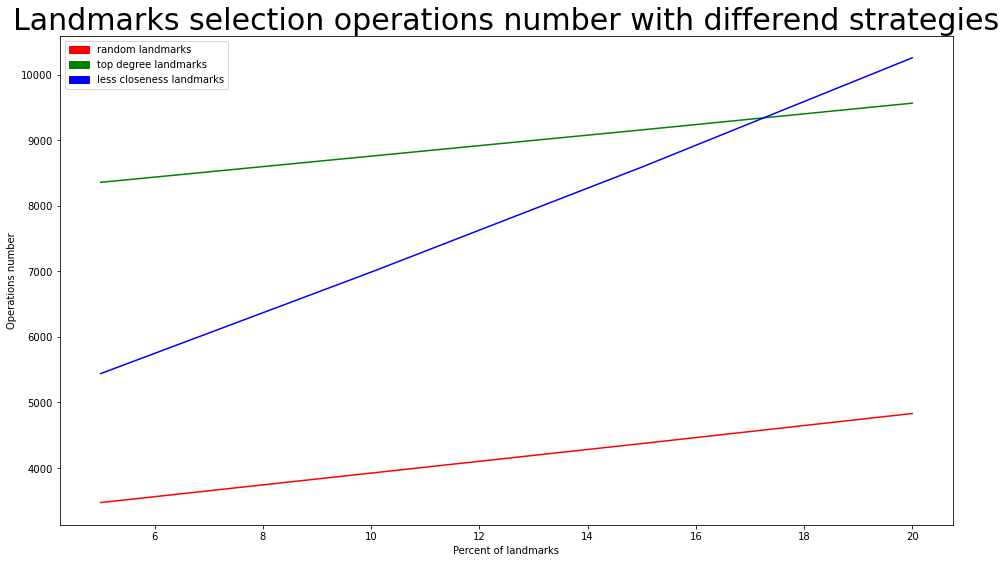

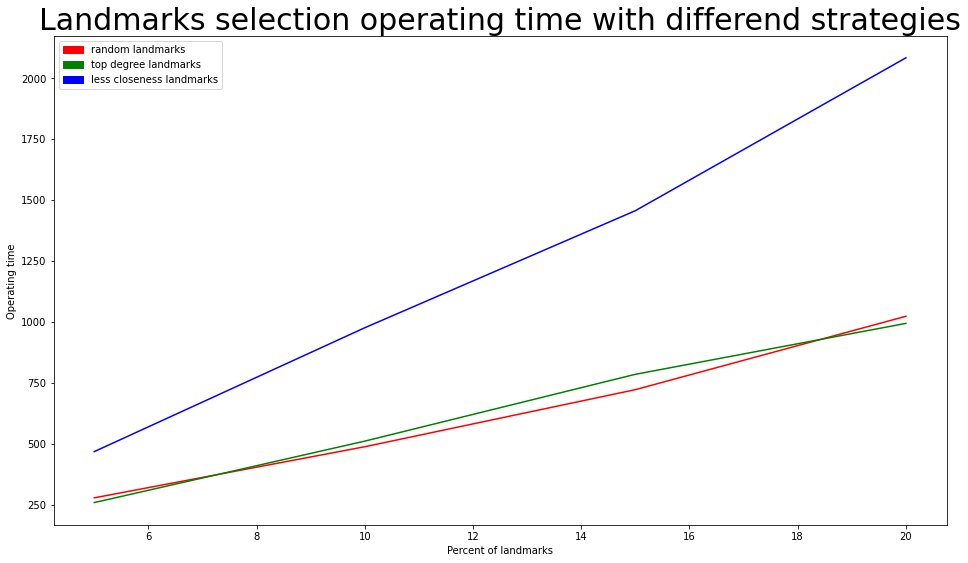

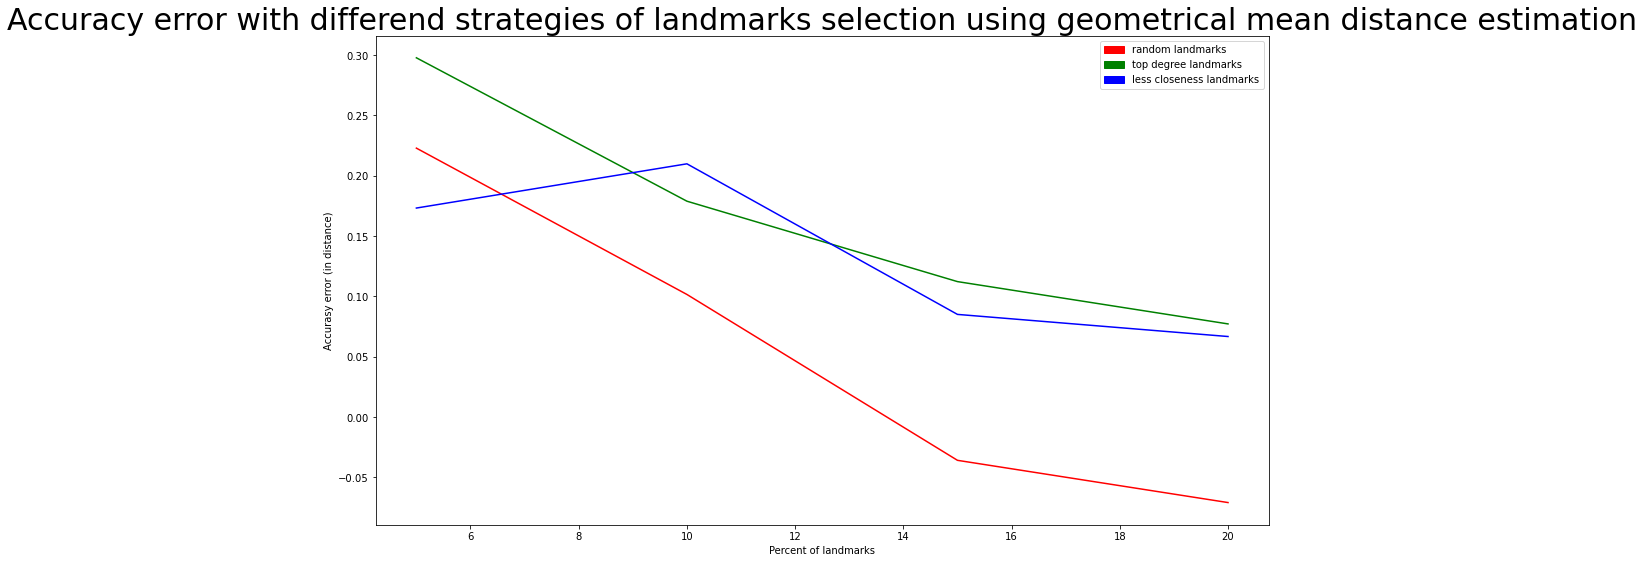

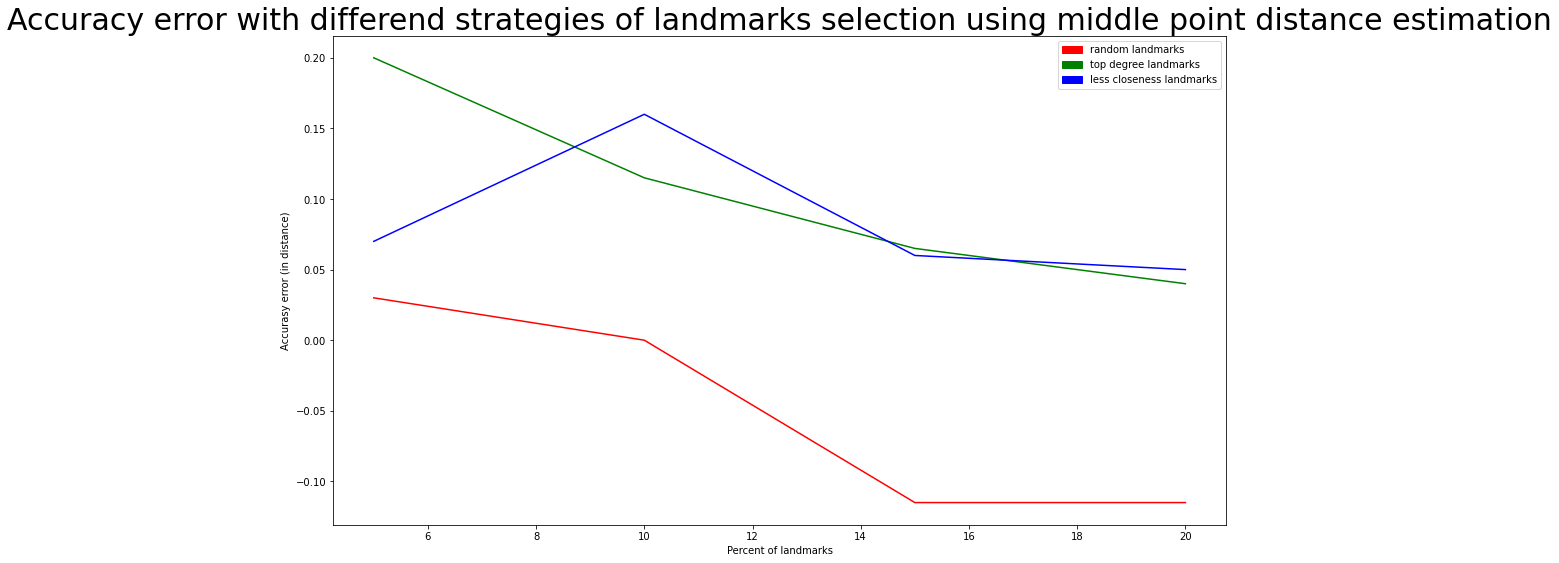

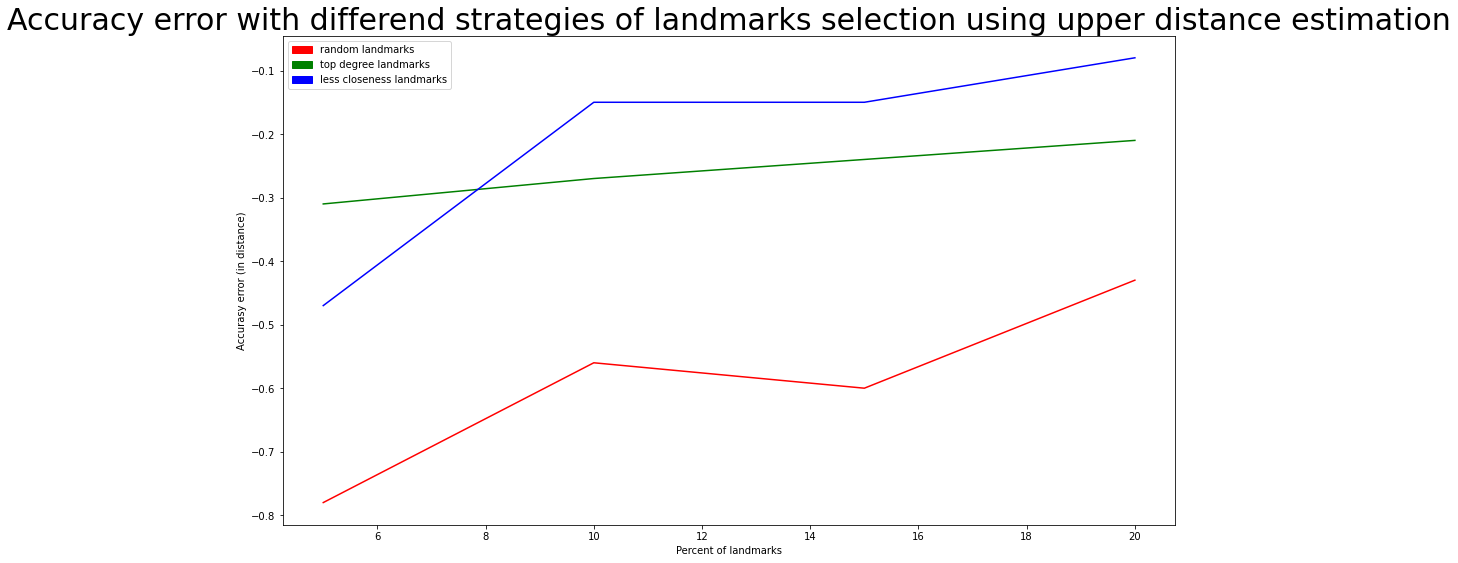

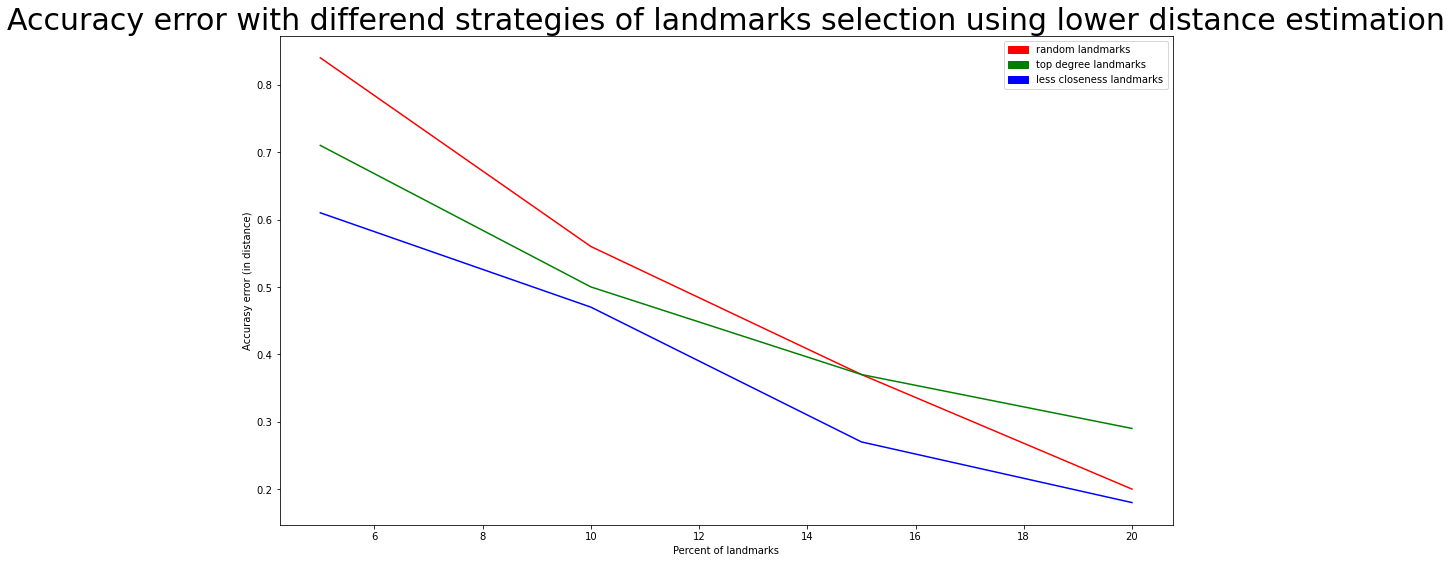

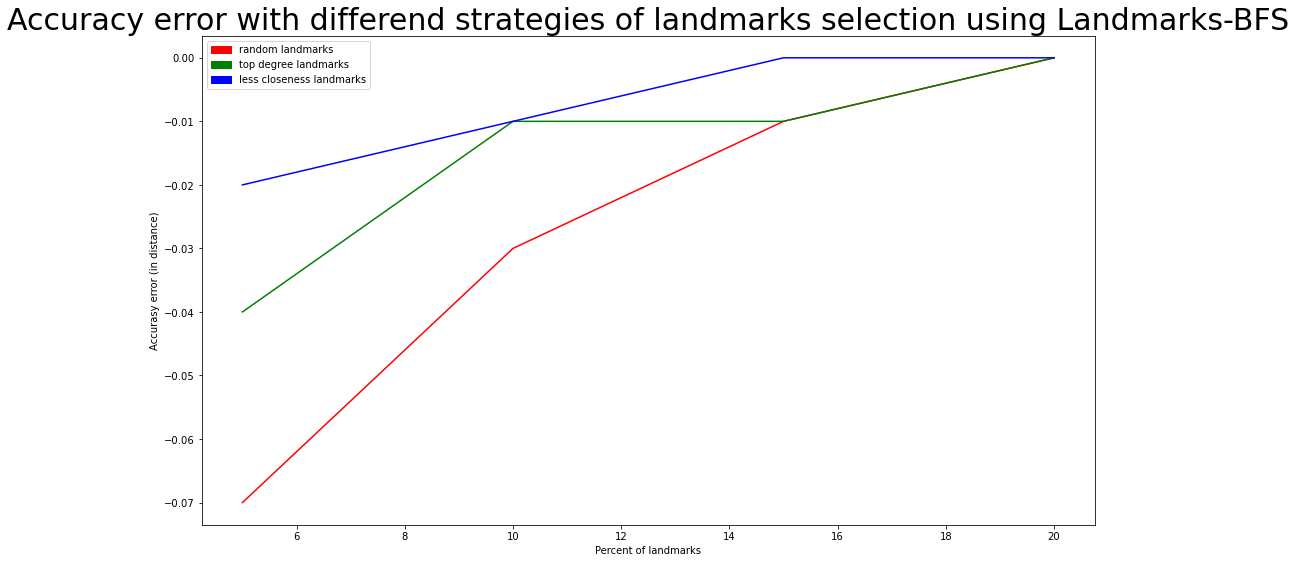

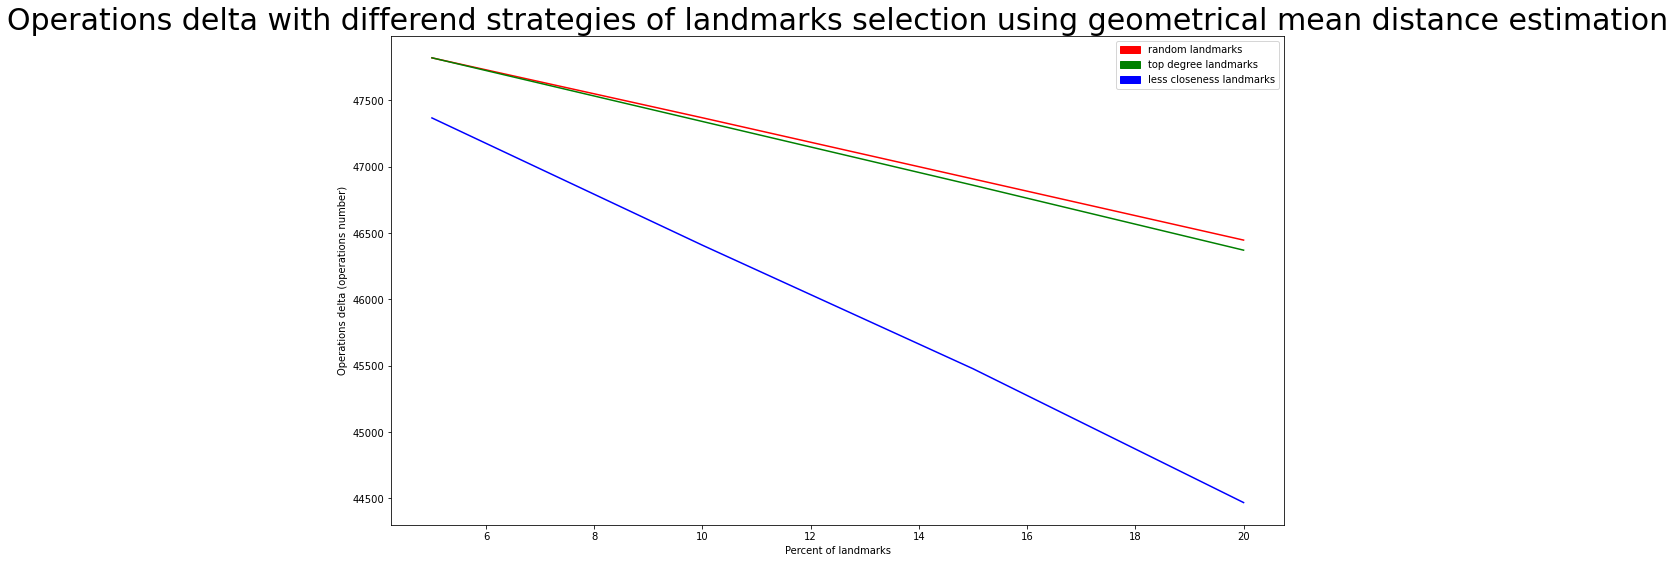

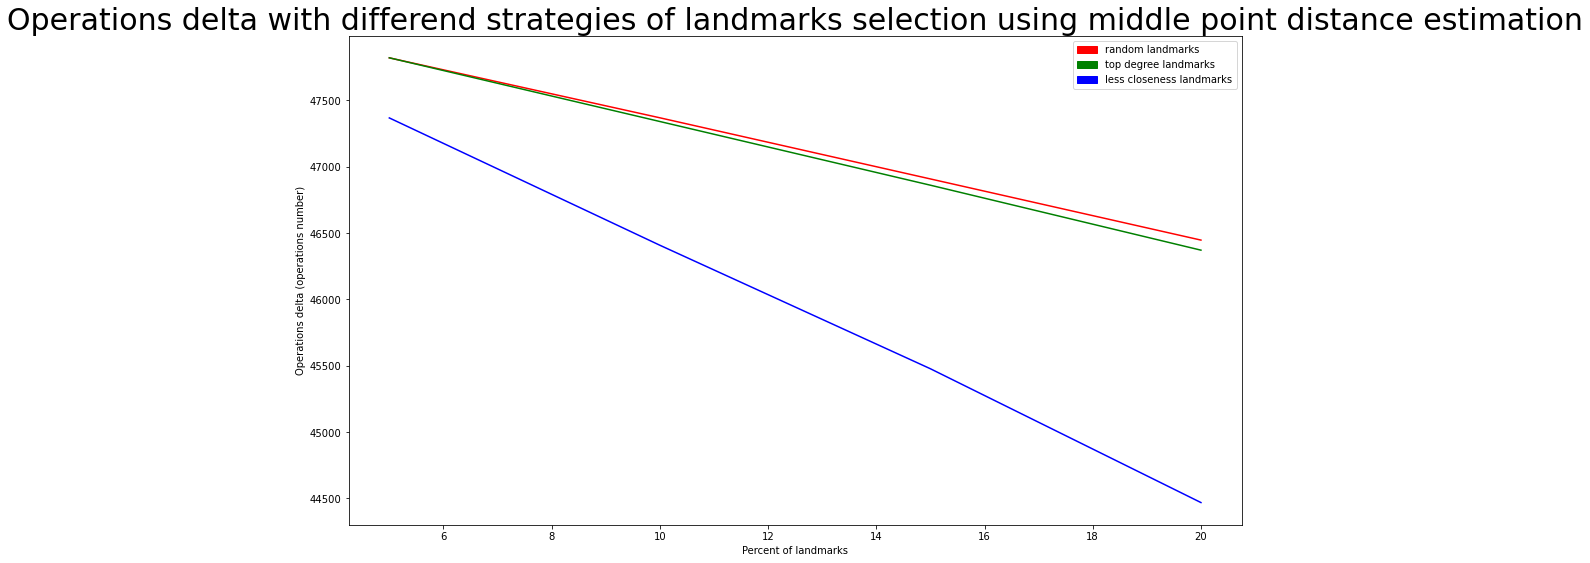

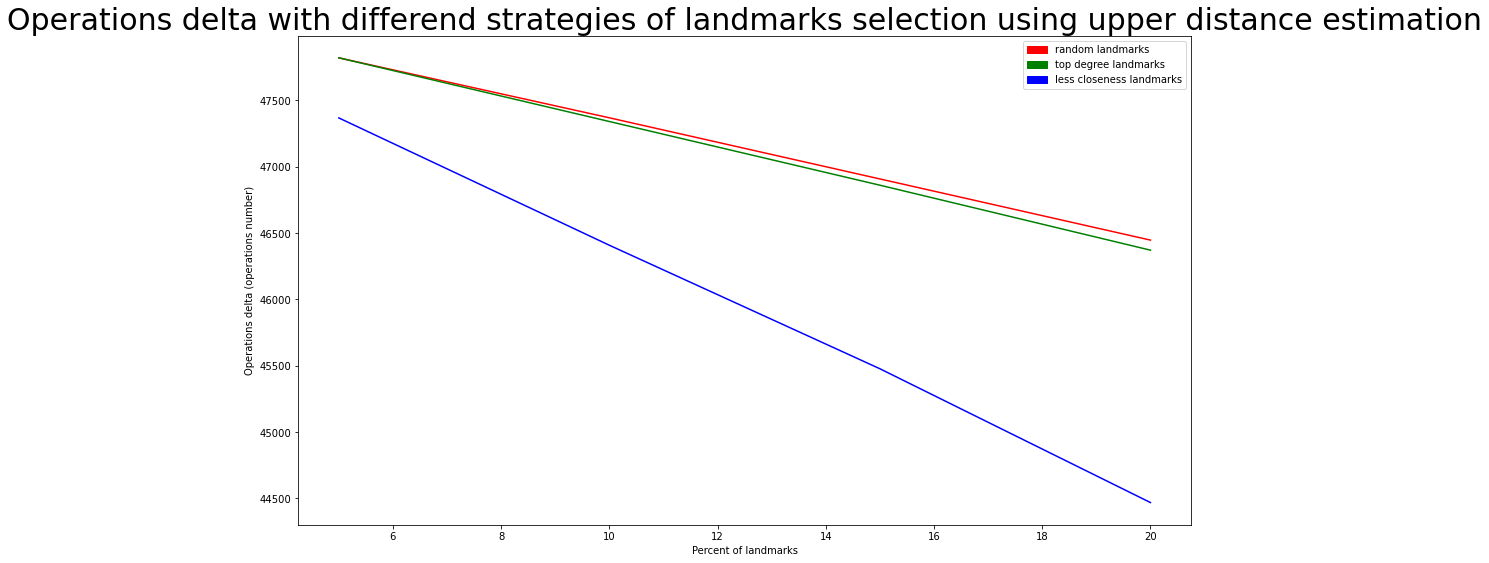

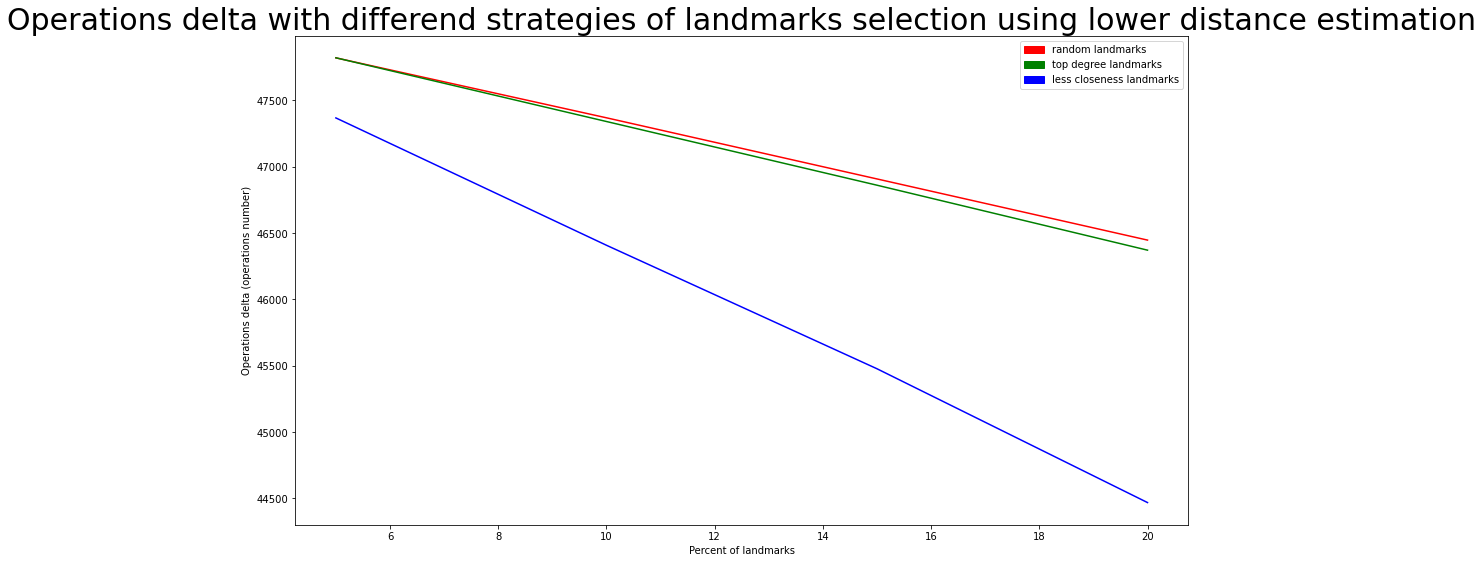

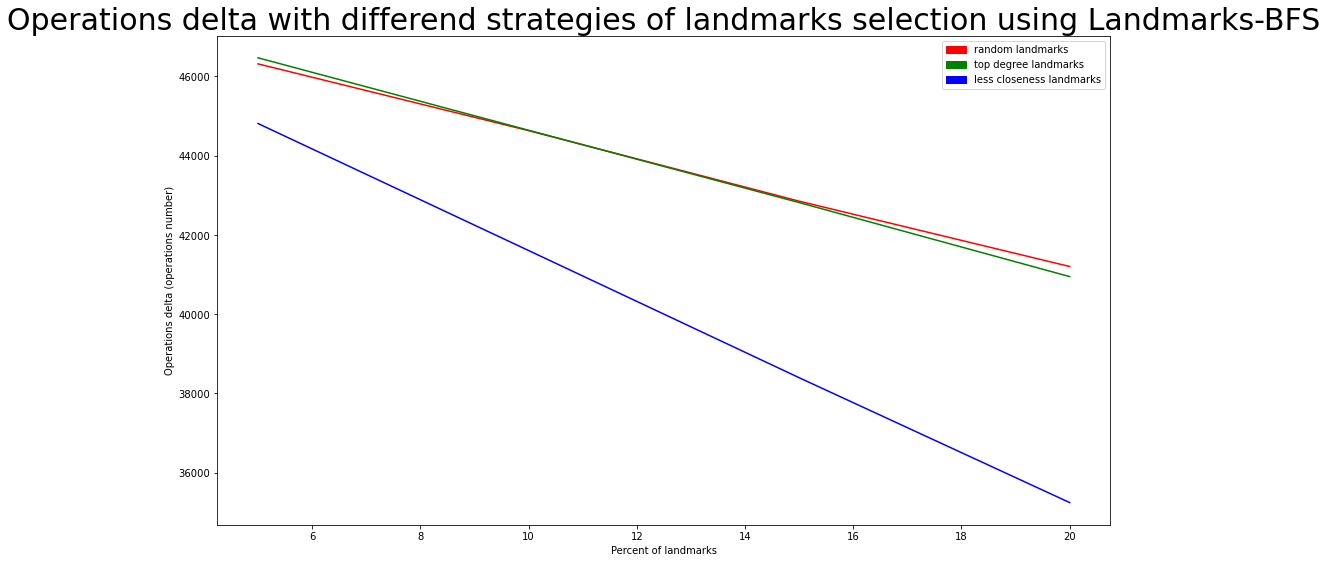

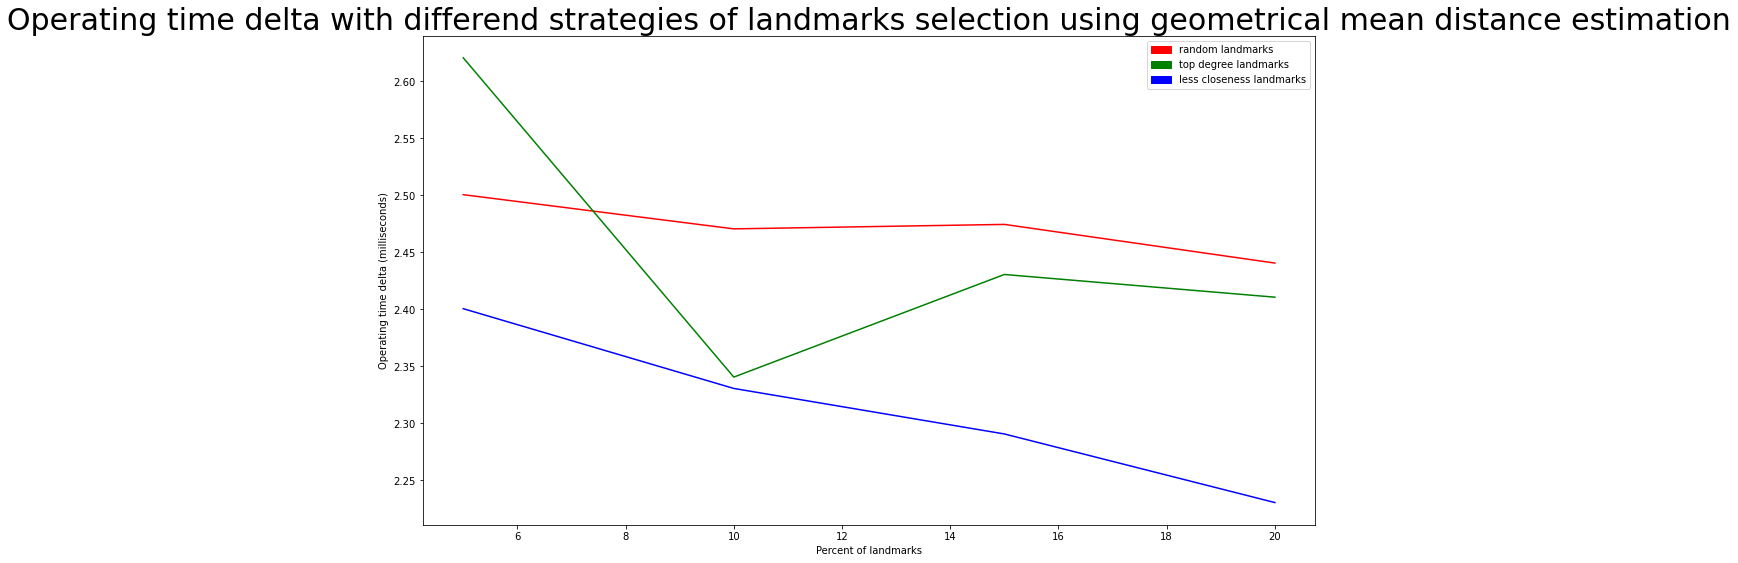

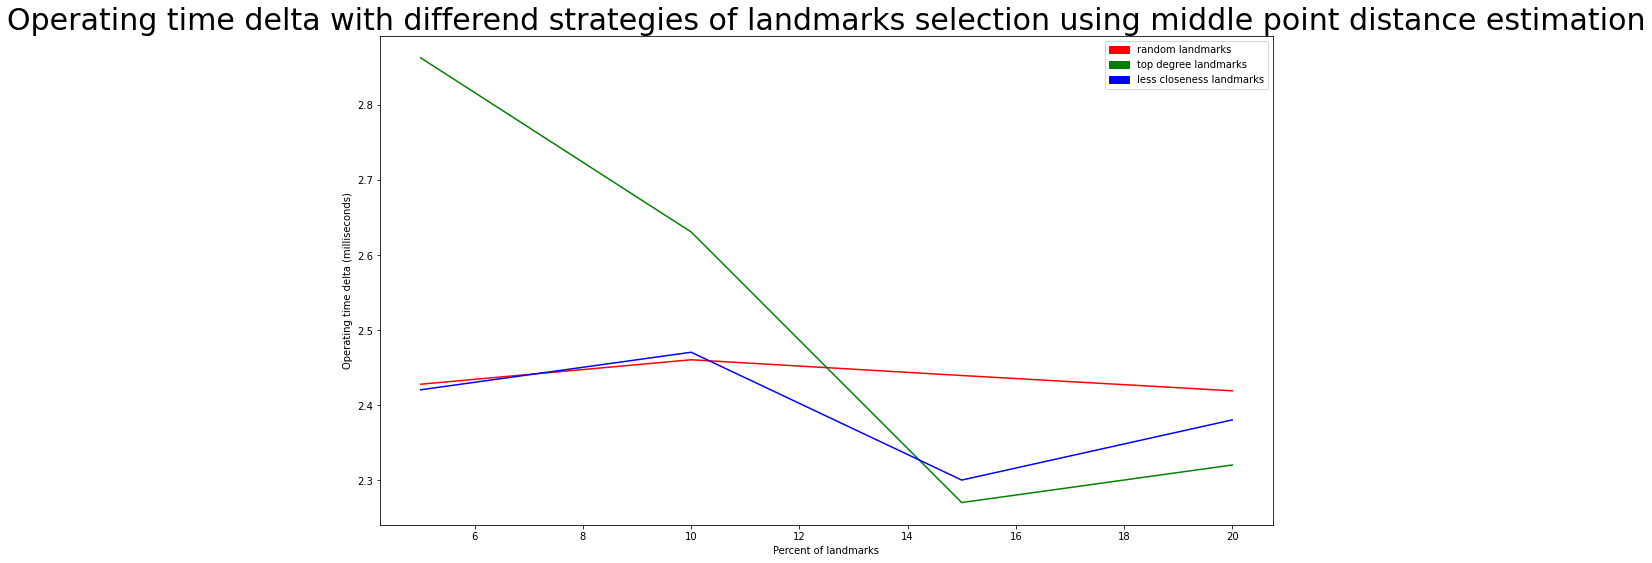

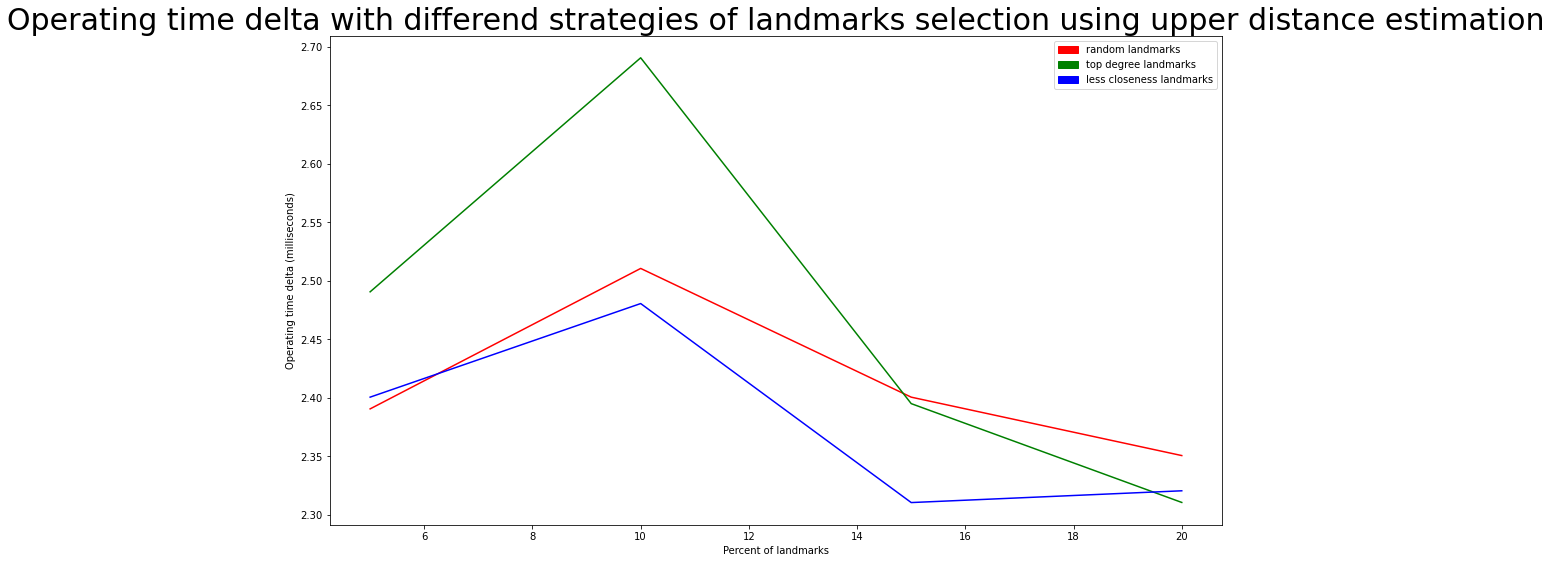

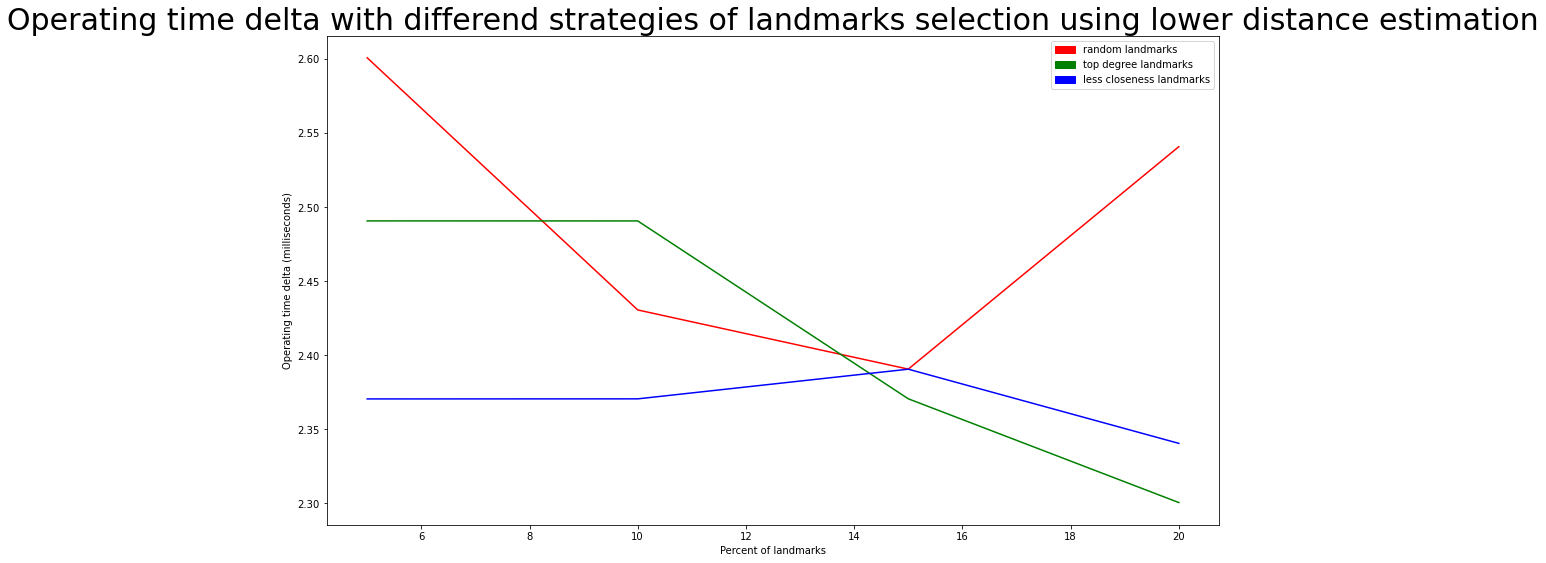

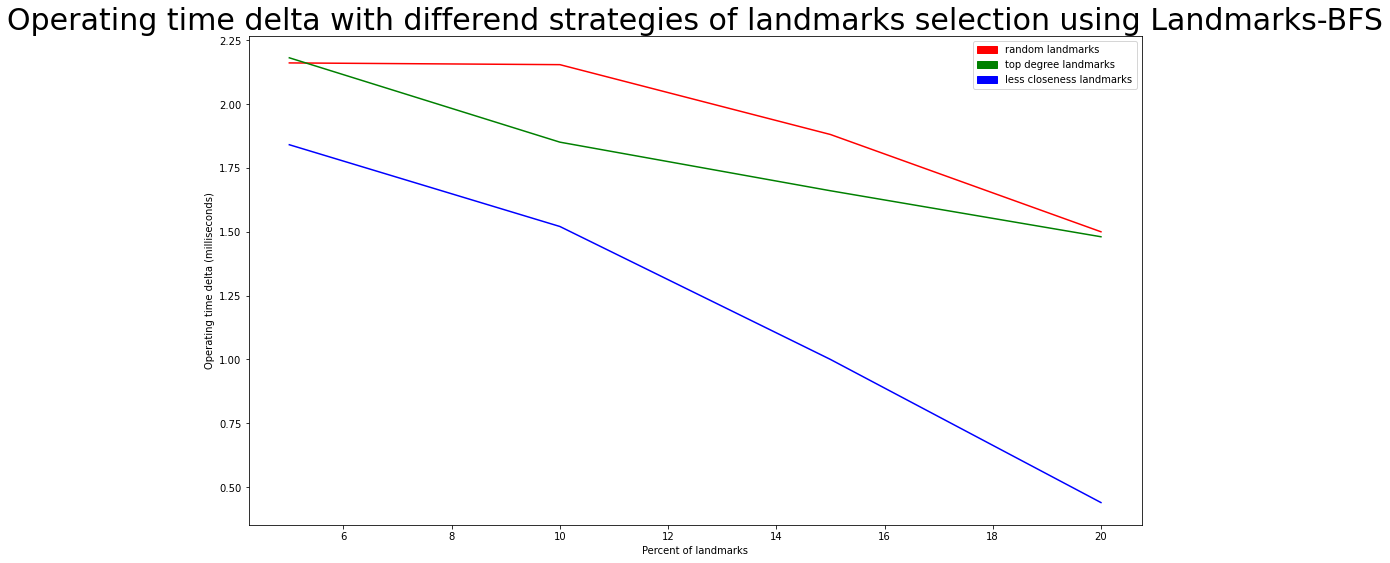

In [14]:
import matplotlib.pyplot as plt


labels = [key for key, value in plot_data['geometrical_mean']['random']['accuracy'].items()]
colors = {'random landmarks': 'red', 'top degree landmarks': 'green', 'less closeness landmarks': 'blue'}


# Landmarks selection operations number

plt.figure(figsize=(16,9))

y1 = [value['selection_operations'] for percent, value in results['random'].items()]
y2 = [value['selection_operations'] for percent, value in results['degree'].items()]
y3 = [value['selection_operations'] for percent, value in results['closeness'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations number')
plt.title('Landmarks selection operations number with differend strategies', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)
if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'selection_operations.jpg', dpi=100, bbox_inches='tight')
plt.show()

# Landmarks selection operating time

plt.figure(figsize=(16,9))

y1 = [value['selection_time'] for percent, value in results['random'].items()]
y2 = [value['selection_time'] for percent, value in results['degree'].items()]
y3 = [value['selection_time'] for percent, value in results['closeness'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time')
plt.title('Landmarks selection operating time with differend strategies', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'selection_time.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Accuracy error with geometrical mean estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['geometrical_mean']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['geometrical_mean']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['geometrical_mean']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using geometrical mean distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_geometrical_mean.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Accuracy error with middle point estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['middle_point']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['middle_point']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['middle_point']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using middle point distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_middle_point.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Accuracy error with upper estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['upper']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['upper']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['upper']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using upper distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_upper.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Accuracy error with lower estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['lower']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['lower']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['lower']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_lower.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Accuracy error with Landmarks-BFS

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['landmarks_bfs']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['landmarks_bfs']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['landmarks_bfs']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using Landmarks-BFS', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_landmarks_bfs.jpg', dpi=100, bbox_inches='tight')
plt.show() 




# Operations delta with geometrical mean estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['geometrical_mean']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['geometrical_mean']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['geometrical_mean']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using geometrical mean distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_geometrical_mean.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations delta with middle point estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['middle_point']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['middle_point']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['middle_point']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using middle point distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_middle_point.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations delta with upper estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['upper']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['upper']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['upper']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using upper distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_upper.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations delta with lower estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['lower']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['lower']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['lower']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_lower.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Operations delta with Landmarks-BFS

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['landmarks_bfs']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['landmarks_bfs']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['landmarks_bfs']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using Landmarks-BFS', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_landmarks_bfs.jpg', dpi=100, bbox_inches='tight')
plt.show()



# Operations time delta with geometrical mean estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['geometrical_mean']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['geometrical_mean']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['geometrical_mean']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using geometrical mean distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_geometrical_mean.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations time delta with middle point estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['middle_point']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['middle_point']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['middle_point']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using middle point distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_middle_point.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations time delta with upper estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['upper']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['upper']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['upper']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using upper distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_upper.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations time delta with lower estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['lower']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['lower']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['lower']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_lower.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Operations time delta with Landmarks-BFS

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['landmarks_bfs']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['landmarks_bfs']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['landmarks_bfs']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using Landmarks-BFS', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_landmarks_bfs.jpg', dpi=100, bbox_inches='tight')
plt.show()